# Military Aircraft Deep Learning Classification Model

In [1]:
import os
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from random import randint
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision import models

import warnings
warnings.filterwarnings("ignore")

## Data Load Transform and Exporting

In [ ]:
# Loading the processed dataset
df = pd.read_csv("military_aircraft_crop.csv")
images = df["images"].values
labels = df["labels"].values

# splitting the dataset into train, validation, and test sets with stratified sampling
sss_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss_1.split(images, labels))

sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss_2.split(images[temp_idx], labels[temp_idx]))

val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Creating a dictionary to hold the indices for each split
unique_labels = sorted(set(labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

with open("label_to_idx.json", "w") as f:
    json.dump(label_to_idx, f, indent=4)

print("✅ label_to_idx.json saved!")
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


✅ label_to_idx.json saved!
Train: 24160, Val: 5177, Test: 5178


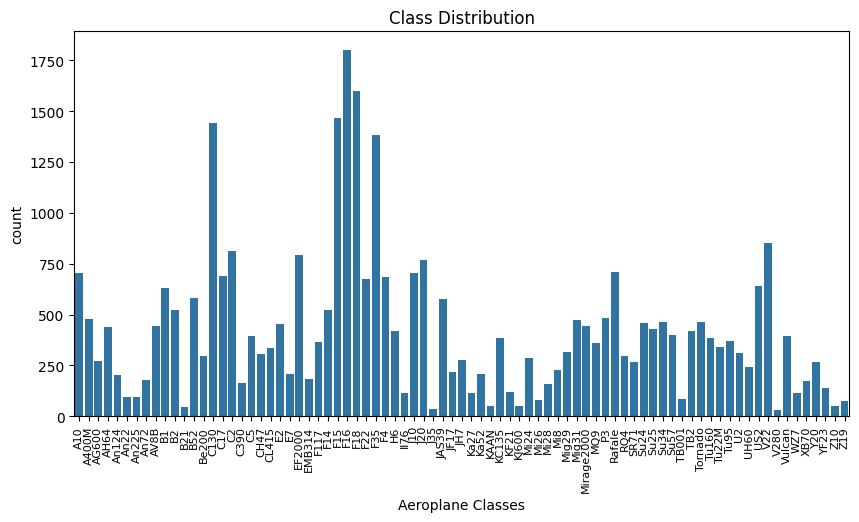

In [ ]:
# getting bar chart of class distribution
mil_data = pd.read_csv("military_aircraft_crop.csv")
plt.figure(figsize=(10, 5))
sns.countplot(x=mil_data.labels)
plt.title("Class Distribution")
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Aeroplane Classes")
plt.show()

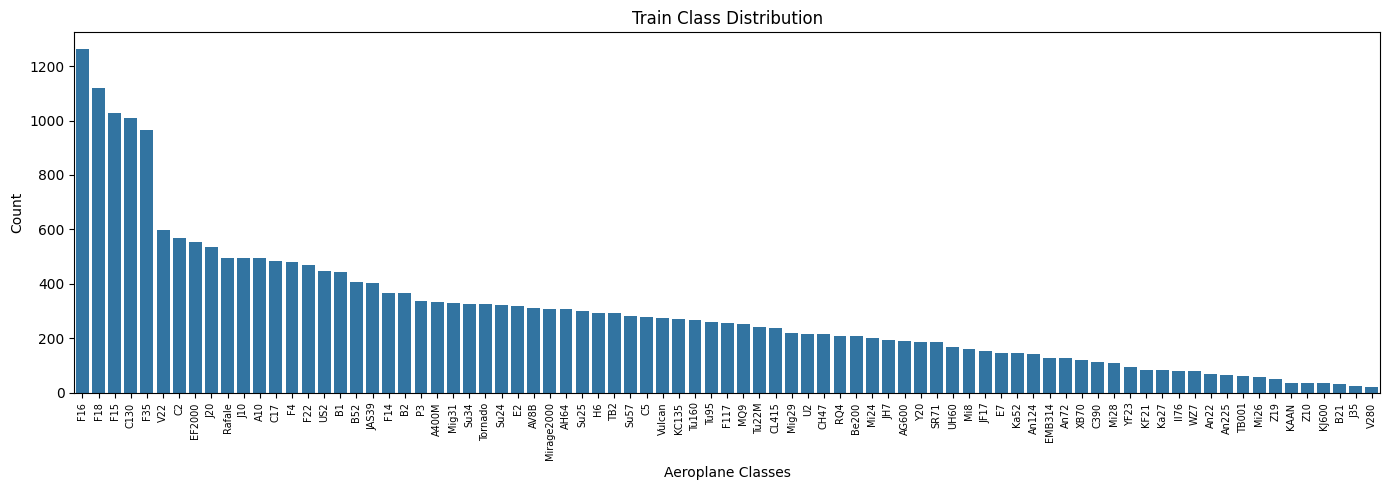

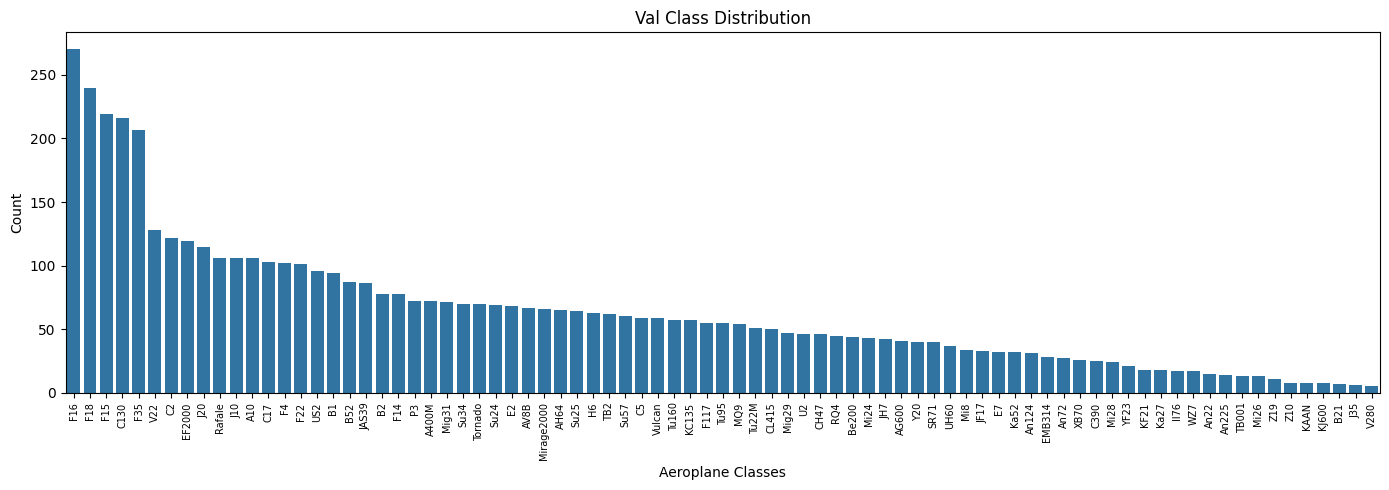

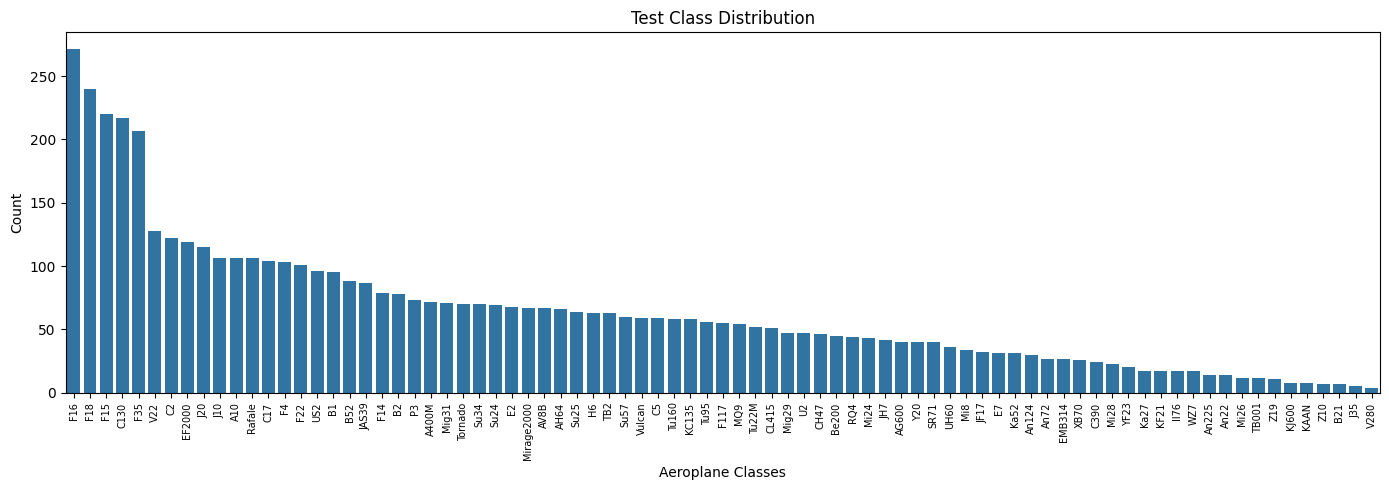

In [ ]:
# getting the distribution of classes in train, val, and test splits
def plot_split_distribution(indices, labels, split_name):
    subset_labels = labels[indices]
    label_counts = pd.Series(subset_labels).value_counts().sort_values(ascending=False)

    plt.figure(figsize=(14, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(f"{split_name} Class Distribution")
    plt.xlabel("Aeroplane Classes")
    plt.ylabel("Count")
    plt.xticks(rotation=90, fontsize=7)
    plt.tight_layout()
    plt.show()
    
# plot class distribution for each split
plot_split_distribution(train_idx, labels, "Train")
plot_split_distribution(val_idx, labels, "Val")
plot_split_distribution(test_idx, labels, "Test")

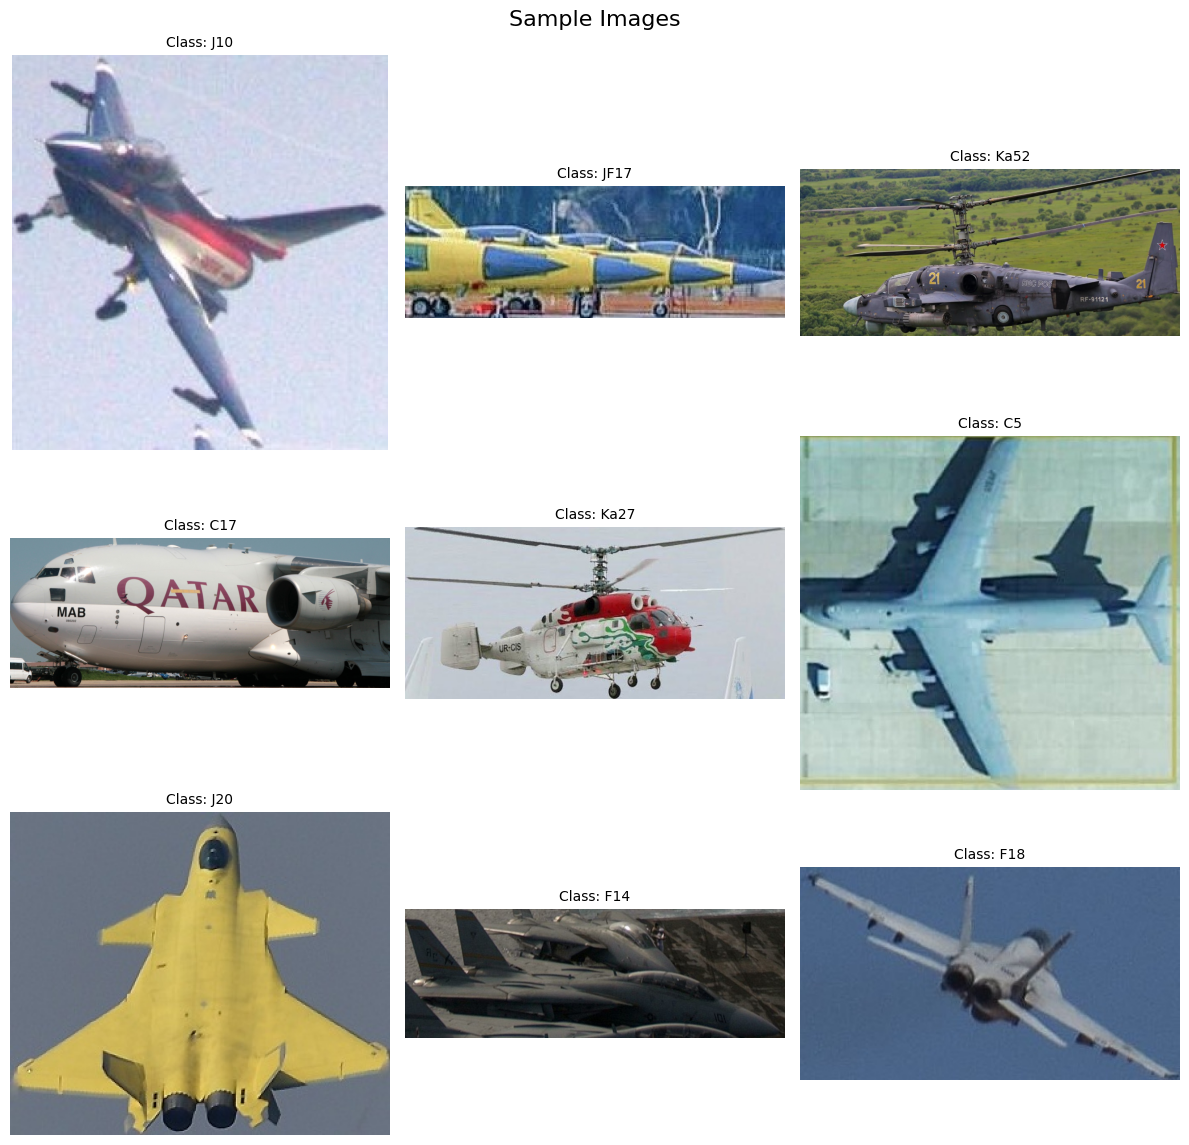

In [5]:
# plot 3 x 3 grid of images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Sample Images", fontsize=16)
for _, ax in enumerate(axes.flat):
    y = randint(0, len(mil_data))
    img = Image.open(mil_data['images'][y])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Class: {mil_data['labels'][y]}", fontsize=10)
plt.tight_layout()
plt.savefig("sample_images.png")
plt.show()

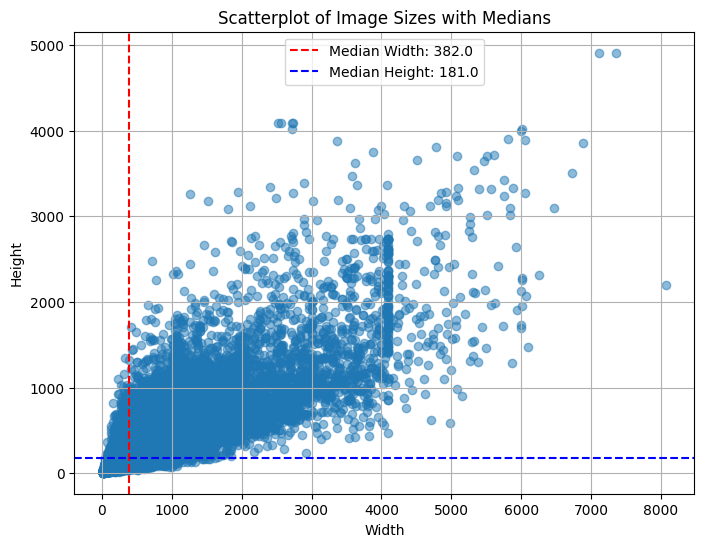

In [8]:
# Getting the median width and height of the images
image_sizes = []
for path in mil_data['images']:
    try:
        with Image.open(path) as img:
            image_sizes.append(img.size)
    except Exception as e:
        print(f"Error reading {path}: {e}")

size_df = pd.DataFrame(image_sizes, columns=['width', 'height'])

median_width = size_df['width'].median()
median_height = size_df['height'].median()

# Plot scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(size_df['width'], size_df['height'], alpha=0.5)
plt.axvline(median_width, color='red', linestyle='--', label=f'Median Width: {median_width}')
plt.axhline(median_height, color='blue', linestyle='--', label=f'Median Height: {median_height}')
plt.title('Scatterplot of Image Sizes with Medians')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Processing the images into tensors
class AircraftTensorDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images  # Tensor: [N, 3, 224, 224]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def load_data(path):
    data = torch.load(path, weights_only=False)
    return data["tensors"], data["labels"]

In [ ]:
# Only loading the training and validation datasets to save time and memory when training models
# Loadin the .pt files extracted in create_pt_files.ipynb
train_images, train_labels = load_data("military_aircraft_crop_train.pt")
val_images, val_labels = load_data("military_aircraft_crop_val.pt")

with open("label_to_idx.json", "r") as f:
    label_to_idx = json.load(f)

# Map class labels to indices
train_labels = [label_to_idx[label] for label in train_labels]
val_labels = [label_to_idx[label] for label in val_labels]

# Create datasets and dataloaders w/ batch size of 64
batch_size = 64
train_dataset = AircraftTensorDataset(train_images, train_labels)
val_dataset = AircraftTensorDataset(val_images, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Same as above but for the validation and test datasets for testing
val_images, val_labels = load_data("military_aircraft_crop_val.pt")
test_images, test_labels = load_data("military_aircraft_crop_test.pt")

with open("label_to_idx.json", "r") as f:
    label_to_idx = json.load(f)

val_labels = [label_to_idx[label] for label in val_labels]
test_labels = [label_to_idx[label] for label in test_labels]

batch_size = 64
val_dataset = AircraftTensorDataset(val_images, val_labels)
test_dataset = AircraftTensorDataset(test_images, test_labels)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training Loop & Metrics Graph Functions

In [ ]:
# Defining the training loop for the models.
# There are hyperparameters that can be set for n_epochs, learning rate, etc.

def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    save_path,
    use_class_weights=False,
    train_labels=None,
    smoothing=0.1,
    patience=5,
    max_lr_reductions=5,
    lr=2e-4,
    num_classes=81
):
    # setting device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True
    print("Device:", device)

    model = model.to(device)

    # Setup cross entropy loss criterion w/ class weights if specified
    if use_class_weights and train_labels is not None:
        class_counts = Counter(train_labels)
        weights = torch.tensor(
            [1.0 / class_counts.get(i, 1.0) for i in range(num_classes)],
            dtype=torch.float
        ).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=smoothing)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)

    # adam optimiser with learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=patience)

    best_val_acc = 0
    prev_lr = lr
    n_lr_reductions = 0
    epochs_without_improvement = 0

    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training the model for each epoch and getting loss and accuracy
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = running_loss / len(train_loader)

        # Applying model to validation set and calculating accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        # applying lr scheduler step to reduce learning rate on failure to improve over n epochs
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]["lr"]

        # if statement to manage early stopping based on lr reductions
        if current_lr != prev_lr:
            print(f"🔁 LR reduced to {current_lr}")
            epochs_without_improvement = 0
            n_lr_reductions += 1
        prev_lr = current_lr

        # statement to save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1
            print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

        if n_lr_reductions >= max_lr_reductions:
            print("⛔ Early stopping! Best Validation Accuracy:", best_val_acc)
            break

    # saving the best performing model
    print("✅ Training complete. Saving best model.")
    torch.save(best_model, save_path)

    # returns the training and validation accuracies, loss, and best validation accuracy
    return {
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "loss": loss_list,
        "best_val_acc": best_val_acc
    }


In [ ]:
# function to plot the loss and train/val accuracy for all the models
def plot_all_training_results(results_dict, title="Model Comparison", save_path=None):
    plt.figure(figsize=(14, 6))
    plt.suptitle(title, fontsize=18)

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    for model_name, metrics in results_dict.items():
        epochs = range(1, len(metrics['train_acc']) + 1)
        plt.plot(epochs, metrics['train_acc'], label=f"{model_name} Train")
        plt.plot(epochs, metrics['val_acc'], label=f"{model_name} Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    # Loss subplot
    plt.subplot(1, 2, 2)
    for model_name, metrics in results_dict.items():
        epochs = range(1, len(metrics['loss']) + 1)
        plt.plot(epochs, metrics['loss'], label=f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"📊 Combined plot saved to {save_path}")
    plt.show()


## CNN Model

In [ ]:
# The CNN model
class AircraftCNN(nn.Module):
    def __init__(self, n_classes=81):
        super(AircraftCNN, self).__init__()
        self.features = nn.Sequential(
            # First conv block, all blocks with batch norm and relu activation
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Third Conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Final conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.classifier = nn.Sequential(
            # Fully connected layers with dropout
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## ResNet Like Model

In [ ]:
# Resnet like model

# basic convolutional residual block with two convolutional layers
class BasicBlock(nn.Module):
    expansion = 1  # Multiplier for output channels; 1 for ResNet-18

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.3),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = downsample  # Optional projection to match dimensions
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # setting up the skip connection
        out = self.block(x)  # Pass through basic block
        if self.downsample is not None:
            identity = self.downsample(x)  # Apply projection if needed
        out += identity  # Add skip connection
        out = self.relu(out)
        return out


# Resnet main body
class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=81):
        super(CustomResNet, self).__init__()
        self.in_channels = 64  # Initial number of feature channels

        # Stem block to reduce resolution and extract low-level features
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Residual layers: each _make_layer creates a stack of residual blocks
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Global feature pooling and dropout for regularization
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.4)

        # fully connected classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * block.expansion, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    # function to create a block of residual layers
    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None

        # If input/output dims don't match, create a downsampling projection
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        # Create the first block with downsampling if needed
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion

        # Create the remaining blocks without downsampling
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


# easier function to call the resnet model
def custom_resnet18(num_classes=81):
    return CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

## Pre-Trained ResNet-18

In [ ]:
# Training function for the pre-trained resnet model from torchvision with custom classifier to output 81 classes
class AircraftResNet(nn.Module):
    def __init__(self, n_classes=81):
        super(AircraftResNet, self).__init__()
        # Using a pre-trained ResNet-18 model from torchvision
        self.backbone = models.resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        return self.backbone(x)

## Train Models and Display Metrics

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.backends.cudnn.benchmark = True

Device: cuda


In [ ]:
# Run the cnn model
cnn_results = train_model(
    model=AircraftCNN(),
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    save_path="best_aircraft_cnn.pth",
    use_class_weights=False,
    smoothing=0.1,
)

🖥️ Device: cuda


100%|██████████| 378/378 [00:41<00:00,  9.11it/s]


Epoch 1/100 | Loss: 4.1750 | Train Acc: 0.0525 | Val Acc: 0.0636 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.63it/s]


Epoch 2/100 | Loss: 4.1013 | Train Acc: 0.0651 | Val Acc: 0.0740 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.68it/s]


Epoch 3/100 | Loss: 4.0699 | Train Acc: 0.0694 | Val Acc: 0.0809 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.64it/s]


Epoch 4/100 | Loss: 4.0397 | Train Acc: 0.0789 | Val Acc: 0.0902 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.63it/s]


Epoch 5/100 | Loss: 4.0061 | Train Acc: 0.0825 | Val Acc: 0.0906 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.63it/s]


Epoch 6/100 | Loss: 3.9746 | Train Acc: 0.0899 | Val Acc: 0.0952 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.62it/s]


Epoch 7/100 | Loss: 3.9406 | Train Acc: 0.0950 | Val Acc: 0.0962 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.61it/s]


Epoch 8/100 | Loss: 3.8991 | Train Acc: 0.1023 | Val Acc: 0.1091 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.64it/s]


Epoch 9/100 | Loss: 3.8603 | Train Acc: 0.1099 | Val Acc: 0.1176 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.63it/s]


Epoch 10/100 | Loss: 3.8306 | Train Acc: 0.1154 | Val Acc: 0.1180 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.68it/s]


Epoch 11/100 | Loss: 3.7905 | Train Acc: 0.1216 | Val Acc: 0.1159 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.67it/s]


Epoch 12/100 | Loss: 3.7593 | Train Acc: 0.1313 | Val Acc: 0.1321 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.65it/s]


Epoch 13/100 | Loss: 3.7242 | Train Acc: 0.1338 | Val Acc: 0.1342 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.61it/s]


Epoch 14/100 | Loss: 3.6946 | Train Acc: 0.1422 | Val Acc: 0.1592 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.65it/s]


Epoch 15/100 | Loss: 3.6680 | Train Acc: 0.1471 | Val Acc: 0.1385 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.63it/s]


Epoch 16/100 | Loss: 3.6357 | Train Acc: 0.1550 | Val Acc: 0.1551 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.64it/s]


Epoch 17/100 | Loss: 3.6081 | Train Acc: 0.1597 | Val Acc: 0.1621 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.63it/s]


Epoch 18/100 | Loss: 3.5866 | Train Acc: 0.1619 | Val Acc: 0.1665 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.65it/s]


Epoch 19/100 | Loss: 3.5559 | Train Acc: 0.1670 | Val Acc: 0.1512 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.88it/s]


Epoch 20/100 | Loss: 3.5343 | Train Acc: 0.1749 | Val Acc: 0.1698 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.80it/s]


Epoch 21/100 | Loss: 3.5085 | Train Acc: 0.1819 | Val Acc: 0.2030 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.80it/s]


Epoch 22/100 | Loss: 3.4855 | Train Acc: 0.1887 | Val Acc: 0.1538 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.86it/s]


Epoch 23/100 | Loss: 3.4645 | Train Acc: 0.1919 | Val Acc: 0.2013 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.83it/s]


Epoch 24/100 | Loss: 3.4412 | Train Acc: 0.1985 | Val Acc: 0.1924 | LR: 2.00e-04
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.80it/s]


Epoch 25/100 | Loss: 3.4288 | Train Acc: 0.1995 | Val Acc: 0.2046 | LR: 2.00e-04


100%|██████████| 378/378 [00:34<00:00, 10.81it/s]


Epoch 26/100 | Loss: 3.4072 | Train Acc: 0.2045 | Val Acc: 0.1764 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.84it/s]


Epoch 27/100 | Loss: 3.3893 | Train Acc: 0.2111 | Val Acc: 0.1868 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.81it/s]


Epoch 28/100 | Loss: 3.3685 | Train Acc: 0.2116 | Val Acc: 0.2071 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.79it/s]


Epoch 29/100 | Loss: 3.3520 | Train Acc: 0.2186 | Val Acc: 0.1922 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.78it/s]


Epoch 30/100 | Loss: 3.3328 | Train Acc: 0.2251 | Val Acc: 0.2192 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.80it/s]


Epoch 31/100 | Loss: 3.3256 | Train Acc: 0.2256 | Val Acc: 0.2250 | LR: 2.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.78it/s]


Epoch 32/100 | Loss: 3.2974 | Train Acc: 0.2299 | Val Acc: 0.1951 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.81it/s]


Epoch 33/100 | Loss: 3.2789 | Train Acc: 0.2332 | Val Acc: 0.2206 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.78it/s]


Epoch 34/100 | Loss: 3.2607 | Train Acc: 0.2409 | Val Acc: 0.2480 | LR: 2.00e-04


100%|██████████| 378/378 [00:34<00:00, 10.81it/s]


Epoch 35/100 | Loss: 3.2511 | Train Acc: 0.2443 | Val Acc: 0.2208 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.81it/s]


Epoch 36/100 | Loss: 3.2394 | Train Acc: 0.2472 | Val Acc: 0.1943 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.83it/s]


Epoch 37/100 | Loss: 3.2159 | Train Acc: 0.2536 | Val Acc: 0.2181 | LR: 2.00e-04
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.82it/s]


Epoch 38/100 | Loss: 3.1974 | Train Acc: 0.2570 | Val Acc: 0.2216 | LR: 2.00e-04
⚠️ No improvement for 4 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.84it/s]


Epoch 39/100 | Loss: 3.1799 | Train Acc: 0.2623 | Val Acc: 0.2328 | LR: 2.00e-04
⚠️ No improvement for 5 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.81it/s]


Epoch 40/100 | Loss: 3.1737 | Train Acc: 0.2659 | Val Acc: 0.2471 | LR: 2.00e-04
🔁 LR reduced to 0.0001
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 10.82it/s]


Epoch 41/100 | Loss: 3.1033 | Train Acc: 0.2827 | Val Acc: 0.2836 | LR: 1.00e-04


100%|██████████| 378/378 [00:35<00:00, 10.80it/s]


Epoch 42/100 | Loss: 3.0776 | Train Acc: 0.2892 | Val Acc: 0.2737 | LR: 1.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.69it/s]


Epoch 43/100 | Loss: 3.0652 | Train Acc: 0.2883 | Val Acc: 0.3013 | LR: 1.00e-04


100%|██████████| 378/378 [00:33<00:00, 11.14it/s]


Epoch 44/100 | Loss: 3.0573 | Train Acc: 0.2898 | Val Acc: 0.3083 | LR: 1.00e-04


100%|██████████| 378/378 [00:34<00:00, 11.08it/s]


Epoch 45/100 | Loss: 3.0482 | Train Acc: 0.2966 | Val Acc: 0.2851 | LR: 1.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 11.09it/s]


Epoch 46/100 | Loss: 3.0302 | Train Acc: 0.3007 | Val Acc: 0.2673 | LR: 1.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 11.08it/s]


Epoch 47/100 | Loss: 3.0313 | Train Acc: 0.2988 | Val Acc: 0.3208 | LR: 1.00e-04


100%|██████████| 378/378 [00:34<00:00, 11.08it/s]


Epoch 48/100 | Loss: 3.0059 | Train Acc: 0.3062 | Val Acc: 0.2969 | LR: 1.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:33<00:00, 11.13it/s]


Epoch 49/100 | Loss: 3.0016 | Train Acc: 0.3062 | Val Acc: 0.3143 | LR: 1.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 11.12it/s]


Epoch 50/100 | Loss: 2.9999 | Train Acc: 0.3079 | Val Acc: 0.3060 | LR: 1.00e-04
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:33<00:00, 11.16it/s]


Epoch 51/100 | Loss: 2.9735 | Train Acc: 0.3135 | Val Acc: 0.2585 | LR: 1.00e-04
⚠️ No improvement for 4 epoch(s).


100%|██████████| 378/378 [00:33<00:00, 11.13it/s]


Epoch 52/100 | Loss: 2.9741 | Train Acc: 0.3180 | Val Acc: 0.2876 | LR: 1.00e-04
⚠️ No improvement for 5 epoch(s).


100%|██████████| 378/378 [00:33<00:00, 11.14it/s]


Epoch 53/100 | Loss: 2.9643 | Train Acc: 0.3172 | Val Acc: 0.2523 | LR: 1.00e-04
🔁 LR reduced to 5e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:33<00:00, 11.16it/s]


Epoch 54/100 | Loss: 2.9175 | Train Acc: 0.3293 | Val Acc: 0.3338 | LR: 5.00e-05


100%|██████████| 378/378 [00:34<00:00, 11.10it/s]


Epoch 55/100 | Loss: 2.9043 | Train Acc: 0.3339 | Val Acc: 0.3404 | LR: 5.00e-05


100%|██████████| 378/378 [00:34<00:00, 11.10it/s]


Epoch 56/100 | Loss: 2.9000 | Train Acc: 0.3355 | Val Acc: 0.3170 | LR: 5.00e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:35<00:00, 10.74it/s]


Epoch 57/100 | Loss: 2.8996 | Train Acc: 0.3358 | Val Acc: 0.3058 | LR: 5.00e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:34<00:00, 11.12it/s]


Epoch 58/100 | Loss: 2.8839 | Train Acc: 0.3407 | Val Acc: 0.3268 | LR: 5.00e-05
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:36<00:00, 10.33it/s]


Epoch 59/100 | Loss: 2.8782 | Train Acc: 0.3435 | Val Acc: 0.3309 | LR: 5.00e-05
⚠️ No improvement for 4 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.18it/s]


Epoch 60/100 | Loss: 2.8716 | Train Acc: 0.3454 | Val Acc: 0.3131 | LR: 5.00e-05
⚠️ No improvement for 5 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.10it/s]


Epoch 61/100 | Loss: 2.8648 | Train Acc: 0.3442 | Val Acc: 0.3429 | LR: 5.00e-05


100%|██████████| 378/378 [00:37<00:00,  9.97it/s]


Epoch 62/100 | Loss: 2.8584 | Train Acc: 0.3438 | Val Acc: 0.3419 | LR: 5.00e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.04it/s]


Epoch 63/100 | Loss: 2.8609 | Train Acc: 0.3494 | Val Acc: 0.3178 | LR: 5.00e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:38<00:00,  9.89it/s]


Epoch 64/100 | Loss: 2.8525 | Train Acc: 0.3479 | Val Acc: 0.3154 | LR: 5.00e-05
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:39<00:00,  9.58it/s]


Epoch 65/100 | Loss: 2.8550 | Train Acc: 0.3502 | Val Acc: 0.3429 | LR: 5.00e-05
⚠️ No improvement for 4 epoch(s).


100%|██████████| 378/378 [00:39<00:00,  9.52it/s]


Epoch 66/100 | Loss: 2.8490 | Train Acc: 0.3496 | Val Acc: 0.3392 | LR: 5.00e-05
⚠️ No improvement for 5 epoch(s).


100%|██████████| 378/378 [00:39<00:00,  9.65it/s]


Epoch 67/100 | Loss: 2.8403 | Train Acc: 0.3522 | Val Acc: 0.3295 | LR: 5.00e-05
🔁 LR reduced to 2.5e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.11it/s]


Epoch 68/100 | Loss: 2.8105 | Train Acc: 0.3610 | Val Acc: 0.3363 | LR: 2.50e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:38<00:00,  9.94it/s]


Epoch 69/100 | Loss: 2.8021 | Train Acc: 0.3647 | Val Acc: 0.3577 | LR: 2.50e-05


100%|██████████| 378/378 [00:39<00:00,  9.68it/s]


Epoch 70/100 | Loss: 2.7988 | Train Acc: 0.3662 | Val Acc: 0.3558 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.03it/s]


Epoch 71/100 | Loss: 2.7880 | Train Acc: 0.3684 | Val Acc: 0.3583 | LR: 2.50e-05


100%|██████████| 378/378 [00:37<00:00, 10.00it/s]


Epoch 72/100 | Loss: 2.7886 | Train Acc: 0.3625 | Val Acc: 0.3572 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.07it/s]


Epoch 73/100 | Loss: 2.7922 | Train Acc: 0.3668 | Val Acc: 0.3481 | LR: 2.50e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:37<00:00,  9.98it/s]


Epoch 74/100 | Loss: 2.7891 | Train Acc: 0.3682 | Val Acc: 0.3535 | LR: 2.50e-05
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:37<00:00,  9.95it/s]


Epoch 75/100 | Loss: 2.7812 | Train Acc: 0.3665 | Val Acc: 0.3585 | LR: 2.50e-05


100%|██████████| 378/378 [00:38<00:00,  9.94it/s]


Epoch 76/100 | Loss: 2.7792 | Train Acc: 0.3726 | Val Acc: 0.3556 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.01it/s]


Epoch 77/100 | Loss: 2.7798 | Train Acc: 0.3646 | Val Acc: 0.3620 | LR: 2.50e-05


100%|██████████| 378/378 [00:37<00:00,  9.98it/s]


Epoch 78/100 | Loss: 2.7747 | Train Acc: 0.3719 | Val Acc: 0.3630 | LR: 2.50e-05


100%|██████████| 378/378 [00:37<00:00, 10.00it/s]


Epoch 79/100 | Loss: 2.7678 | Train Acc: 0.3752 | Val Acc: 0.3583 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.02it/s]


Epoch 80/100 | Loss: 2.7760 | Train Acc: 0.3686 | Val Acc: 0.3562 | LR: 2.50e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.03it/s]


Epoch 81/100 | Loss: 2.7617 | Train Acc: 0.3755 | Val Acc: 0.3662 | LR: 2.50e-05


100%|██████████| 378/378 [00:37<00:00, 10.02it/s]


Epoch 82/100 | Loss: 2.7656 | Train Acc: 0.3764 | Val Acc: 0.3628 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.03it/s]


Epoch 83/100 | Loss: 2.7553 | Train Acc: 0.3772 | Val Acc: 0.3608 | LR: 2.50e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.03it/s]


Epoch 84/100 | Loss: 2.7643 | Train Acc: 0.3730 | Val Acc: 0.3633 | LR: 2.50e-05
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.09it/s]


Epoch 85/100 | Loss: 2.7532 | Train Acc: 0.3770 | Val Acc: 0.3456 | LR: 2.50e-05
⚠️ No improvement for 4 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.08it/s]


Epoch 86/100 | Loss: 2.7589 | Train Acc: 0.3769 | Val Acc: 0.3674 | LR: 2.50e-05


100%|██████████| 378/378 [00:37<00:00, 10.06it/s]


Epoch 87/100 | Loss: 2.7458 | Train Acc: 0.3796 | Val Acc: 0.3695 | LR: 2.50e-05


100%|██████████| 378/378 [00:37<00:00, 10.04it/s]


Epoch 88/100 | Loss: 2.7465 | Train Acc: 0.3789 | Val Acc: 0.3523 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.09it/s]


Epoch 89/100 | Loss: 2.7504 | Train Acc: 0.3761 | Val Acc: 0.3647 | LR: 2.50e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.07it/s]


Epoch 90/100 | Loss: 2.7445 | Train Acc: 0.3831 | Val Acc: 0.3575 | LR: 2.50e-05
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.06it/s]


Epoch 91/100 | Loss: 2.7405 | Train Acc: 0.3796 | Val Acc: 0.3608 | LR: 2.50e-05
⚠️ No improvement for 4 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.01it/s]


Epoch 92/100 | Loss: 2.7338 | Train Acc: 0.3817 | Val Acc: 0.3579 | LR: 2.50e-05
⚠️ No improvement for 5 epoch(s).


100%|██████████| 378/378 [00:38<00:00,  9.72it/s]


Epoch 93/100 | Loss: 2.7317 | Train Acc: 0.3861 | Val Acc: 0.3583 | LR: 2.50e-05
🔁 LR reduced to 1.25e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:38<00:00,  9.92it/s]


Epoch 94/100 | Loss: 2.7177 | Train Acc: 0.3851 | Val Acc: 0.3711 | LR: 1.25e-05


100%|██████████| 378/378 [00:37<00:00, 10.07it/s]


Epoch 95/100 | Loss: 2.7113 | Train Acc: 0.3912 | Val Acc: 0.3657 | LR: 1.25e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.01it/s]


Epoch 96/100 | Loss: 2.7049 | Train Acc: 0.3952 | Val Acc: 0.3597 | LR: 1.25e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.00it/s]


Epoch 97/100 | Loss: 2.7132 | Train Acc: 0.3870 | Val Acc: 0.3643 | LR: 1.25e-05
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:37<00:00, 10.00it/s]


Epoch 98/100 | Loss: 2.7138 | Train Acc: 0.3905 | Val Acc: 0.3757 | LR: 1.25e-05


100%|██████████| 378/378 [00:37<00:00,  9.96it/s]


Epoch 99/100 | Loss: 2.7031 | Train Acc: 0.3938 | Val Acc: 0.3678 | LR: 1.25e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:37<00:00,  9.99it/s]


Epoch 100/100 | Loss: 2.7099 | Train Acc: 0.3879 | Val Acc: 0.3651 | LR: 1.25e-05
⚠️ No improvement for 2 epoch(s).
✅ Training complete. Saving best model.


In [ ]:
# running the custom resnet model
resnet_results = train_model(
    model=custom_resnet18(num_classes=81),
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    save_path="best_aircraft_res.pth",
    use_class_weights=True,
    train_labels=train_labels,
    smoothing=0.1,
    max_lr_reductions = 4,
    patience=2
)

🖥️ Device: cuda


100%|██████████| 378/378 [00:20<00:00, 18.53it/s]


Epoch 1/100 | Loss: 4.9543 | Train Acc: 0.0088 | Val Acc: 0.0108 | LR: 2.00e-04


100%|██████████| 378/378 [00:19<00:00, 19.07it/s]


Epoch 2/100 | Loss: 4.9030 | Train Acc: 0.0106 | Val Acc: 0.0122 | LR: 2.00e-04


100%|██████████| 378/378 [00:19<00:00, 18.98it/s]


Epoch 3/100 | Loss: 4.8726 | Train Acc: 0.0135 | Val Acc: 0.0075 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.59it/s]


Epoch 4/100 | Loss: 4.8322 | Train Acc: 0.0132 | Val Acc: 0.0156 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.55it/s]


Epoch 5/100 | Loss: 4.7627 | Train Acc: 0.0181 | Val Acc: 0.0274 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.68it/s]


Epoch 6/100 | Loss: 4.6935 | Train Acc: 0.0261 | Val Acc: 0.0357 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.72it/s]


Epoch 7/100 | Loss: 4.6367 | Train Acc: 0.0320 | Val Acc: 0.0379 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.72it/s]


Epoch 8/100 | Loss: 4.5618 | Train Acc: 0.0401 | Val Acc: 0.0512 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.62it/s]


Epoch 9/100 | Loss: 4.5072 | Train Acc: 0.0487 | Val Acc: 0.0639 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.65it/s]


Epoch 10/100 | Loss: 4.4206 | Train Acc: 0.0576 | Val Acc: 0.0719 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.72it/s]


Epoch 11/100 | Loss: 4.3472 | Train Acc: 0.0680 | Val Acc: 0.0836 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.71it/s]


Epoch 12/100 | Loss: 4.2592 | Train Acc: 0.0809 | Val Acc: 0.0865 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.28it/s]


Epoch 13/100 | Loss: 4.1706 | Train Acc: 0.0946 | Val Acc: 0.1099 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.47it/s]


Epoch 14/100 | Loss: 4.0710 | Train Acc: 0.1116 | Val Acc: 0.1285 | LR: 2.00e-04


100%|██████████| 378/378 [00:20<00:00, 18.39it/s]


Epoch 15/100 | Loss: 3.9688 | Train Acc: 0.1254 | Val Acc: 0.1172 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:18<00:00, 20.21it/s]


Epoch 16/100 | Loss: 3.8746 | Train Acc: 0.1447 | Val Acc: 0.1507 | LR: 2.00e-04


100%|██████████| 378/378 [00:18<00:00, 20.18it/s]


Epoch 17/100 | Loss: 3.7825 | Train Acc: 0.1599 | Val Acc: 0.1681 | LR: 2.00e-04


100%|██████████| 378/378 [00:18<00:00, 20.19it/s]


Epoch 18/100 | Loss: 3.6719 | Train Acc: 0.1843 | Val Acc: 0.1829 | LR: 2.00e-04


100%|██████████| 378/378 [00:18<00:00, 20.24it/s]


Epoch 19/100 | Loss: 3.5813 | Train Acc: 0.2047 | Val Acc: 0.1955 | LR: 2.00e-04


100%|██████████| 378/378 [00:18<00:00, 20.18it/s]


Epoch 20/100 | Loss: 3.4759 | Train Acc: 0.2276 | Val Acc: 0.2229 | LR: 2.00e-04


100%|██████████| 378/378 [00:18<00:00, 20.28it/s]


Epoch 21/100 | Loss: 3.3642 | Train Acc: 0.2515 | Val Acc: 0.2281 | LR: 2.00e-04


100%|██████████| 378/378 [00:18<00:00, 20.21it/s]


Epoch 22/100 | Loss: 3.2773 | Train Acc: 0.2798 | Val Acc: 0.2268 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.32it/s]


Epoch 23/100 | Loss: 3.1692 | Train Acc: 0.3012 | Val Acc: 0.2283 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.45it/s]


Epoch 24/100 | Loss: 3.0784 | Train Acc: 0.3262 | Val Acc: 0.2395 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.51it/s]


Epoch 25/100 | Loss: 2.9903 | Train Acc: 0.3577 | Val Acc: 0.2913 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.39it/s]


Epoch 26/100 | Loss: 2.8960 | Train Acc: 0.3850 | Val Acc: 0.2612 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.52it/s]


Epoch 27/100 | Loss: 2.8028 | Train Acc: 0.4175 | Val Acc: 0.2923 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.50it/s]


Epoch 28/100 | Loss: 2.7349 | Train Acc: 0.4417 | Val Acc: 0.2762 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.63it/s]


Epoch 29/100 | Loss: 2.6474 | Train Acc: 0.4744 | Val Acc: 0.3154 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.58it/s]


Epoch 30/100 | Loss: 2.5782 | Train Acc: 0.5003 | Val Acc: 0.2942 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.55it/s]


Epoch 31/100 | Loss: 2.5249 | Train Acc: 0.5195 | Val Acc: 0.3483 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.64it/s]


Epoch 32/100 | Loss: 2.4584 | Train Acc: 0.5517 | Val Acc: 0.3363 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.70it/s]


Epoch 33/100 | Loss: 2.3882 | Train Acc: 0.5778 | Val Acc: 0.3421 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.68it/s]


Epoch 34/100 | Loss: 2.3349 | Train Acc: 0.6039 | Val Acc: 0.3786 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.69it/s]


Epoch 35/100 | Loss: 2.2949 | Train Acc: 0.6252 | Val Acc: 0.3875 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.59it/s]


Epoch 36/100 | Loss: 2.2348 | Train Acc: 0.6491 | Val Acc: 0.3697 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.67it/s]


Epoch 37/100 | Loss: 2.1970 | Train Acc: 0.6723 | Val Acc: 0.3886 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.58it/s]


Epoch 38/100 | Loss: 2.1485 | Train Acc: 0.6950 | Val Acc: 0.3834 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.57it/s]


Epoch 39/100 | Loss: 2.1212 | Train Acc: 0.7115 | Val Acc: 0.4101 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.62it/s]


Epoch 40/100 | Loss: 2.0890 | Train Acc: 0.7313 | Val Acc: 0.3587 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.72it/s]


Epoch 41/100 | Loss: 2.0595 | Train Acc: 0.7462 | Val Acc: 0.4128 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.71it/s]


Epoch 42/100 | Loss: 2.0267 | Train Acc: 0.7653 | Val Acc: 0.3998 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.63it/s]


Epoch 43/100 | Loss: 2.0045 | Train Acc: 0.7813 | Val Acc: 0.4134 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.77it/s]


Epoch 44/100 | Loss: 1.9741 | Train Acc: 0.7959 | Val Acc: 0.4398 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.84it/s]


Epoch 45/100 | Loss: 1.9632 | Train Acc: 0.8039 | Val Acc: 0.4089 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.82it/s]


Epoch 46/100 | Loss: 1.9281 | Train Acc: 0.8227 | Val Acc: 0.4294 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.74it/s]


Epoch 47/100 | Loss: 1.9123 | Train Acc: 0.8326 | Val Acc: 0.4493 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.62it/s]


Epoch 48/100 | Loss: 1.8914 | Train Acc: 0.8473 | Val Acc: 0.4694 | LR: 2.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.67it/s]


Epoch 49/100 | Loss: 1.8838 | Train Acc: 0.8540 | Val Acc: 0.4449 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.67it/s]


Epoch 50/100 | Loss: 1.8647 | Train Acc: 0.8629 | Val Acc: 0.4628 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.74it/s]


Epoch 51/100 | Loss: 1.8514 | Train Acc: 0.8703 | Val Acc: 0.4532 | LR: 2.00e-04
🔁 LR reduced to 0.0001
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 16.81it/s]


Epoch 52/100 | Loss: 1.7903 | Train Acc: 0.9044 | Val Acc: 0.4949 | LR: 1.00e-04


100%|██████████| 378/378 [00:22<00:00, 16.68it/s]


Epoch 53/100 | Loss: 1.7625 | Train Acc: 0.9231 | Val Acc: 0.4816 | LR: 1.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 16.60it/s]


Epoch 54/100 | Loss: 1.7549 | Train Acc: 0.9271 | Val Acc: 0.4943 | LR: 1.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 16.77it/s]


Epoch 55/100 | Loss: 1.7466 | Train Acc: 0.9322 | Val Acc: 0.5001 | LR: 1.00e-04


100%|██████████| 378/378 [00:22<00:00, 16.97it/s]


Epoch 56/100 | Loss: 1.7369 | Train Acc: 0.9375 | Val Acc: 0.4987 | LR: 1.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.62it/s]


Epoch 57/100 | Loss: 1.7329 | Train Acc: 0.9406 | Val Acc: 0.4796 | LR: 1.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.53it/s]


Epoch 58/100 | Loss: 1.7239 | Train Acc: 0.9449 | Val Acc: 0.5022 | LR: 1.00e-04


100%|██████████| 378/378 [00:21<00:00, 17.41it/s]


Epoch 59/100 | Loss: 1.7164 | Train Acc: 0.9471 | Val Acc: 0.4906 | LR: 1.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.56it/s]


Epoch 60/100 | Loss: 1.7127 | Train Acc: 0.9512 | Val Acc: 0.4987 | LR: 1.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.46it/s]


Epoch 61/100 | Loss: 1.7033 | Train Acc: 0.9536 | Val Acc: 0.5011 | LR: 1.00e-04
🔁 LR reduced to 5e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 17.15it/s]


Epoch 62/100 | Loss: 1.6909 | Train Acc: 0.9639 | Val Acc: 0.5121 | LR: 5.00e-05


100%|██████████| 378/378 [00:22<00:00, 17.10it/s]


Epoch 63/100 | Loss: 1.6852 | Train Acc: 0.9643 | Val Acc: 0.5084 | LR: 5.00e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:20<00:00, 18.10it/s]


Epoch 64/100 | Loss: 1.6792 | Train Acc: 0.9682 | Val Acc: 0.5130 | LR: 5.00e-05


100%|██████████| 378/378 [00:21<00:00, 17.98it/s]


Epoch 65/100 | Loss: 1.6738 | Train Acc: 0.9709 | Val Acc: 0.5078 | LR: 5.00e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.63it/s]


Epoch 66/100 | Loss: 1.6706 | Train Acc: 0.9739 | Val Acc: 0.5155 | LR: 5.00e-05


100%|██████████| 378/378 [00:21<00:00, 17.79it/s]


Epoch 67/100 | Loss: 1.6662 | Train Acc: 0.9717 | Val Acc: 0.5181 | LR: 5.00e-05


100%|██████████| 378/378 [00:21<00:00, 17.82it/s]


Epoch 68/100 | Loss: 1.6552 | Train Acc: 0.9748 | Val Acc: 0.5208 | LR: 5.00e-05


100%|██████████| 378/378 [00:22<00:00, 17.17it/s]


Epoch 69/100 | Loss: 1.6561 | Train Acc: 0.9763 | Val Acc: 0.5188 | LR: 5.00e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 17.04it/s]


Epoch 70/100 | Loss: 1.6547 | Train Acc: 0.9781 | Val Acc: 0.5184 | LR: 5.00e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 17.02it/s]


Epoch 71/100 | Loss: 1.6535 | Train Acc: 0.9781 | Val Acc: 0.5206 | LR: 5.00e-05
🔁 LR reduced to 2.5e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.41it/s]


Epoch 72/100 | Loss: 1.6470 | Train Acc: 0.9795 | Val Acc: 0.5206 | LR: 2.50e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 17.09it/s]


Epoch 73/100 | Loss: 1.6423 | Train Acc: 0.9822 | Val Acc: 0.5204 | LR: 2.50e-05
⚠️ No improvement for 3 epoch(s).


100%|██████████| 378/378 [00:22<00:00, 17.14it/s]


Epoch 74/100 | Loss: 1.6419 | Train Acc: 0.9820 | Val Acc: 0.5213 | LR: 2.50e-05


100%|██████████| 378/378 [00:21<00:00, 17.90it/s]


Epoch 75/100 | Loss: 1.6450 | Train Acc: 0.9822 | Val Acc: 0.5206 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:19<00:00, 19.14it/s]


Epoch 76/100 | Loss: 1.6433 | Train Acc: 0.9842 | Val Acc: 0.5237 | LR: 2.50e-05


100%|██████████| 378/378 [00:21<00:00, 17.28it/s]


Epoch 77/100 | Loss: 1.6342 | Train Acc: 0.9858 | Val Acc: 0.5262 | LR: 2.50e-05


100%|██████████| 378/378 [00:22<00:00, 17.03it/s]


Epoch 78/100 | Loss: 1.6354 | Train Acc: 0.9843 | Val Acc: 0.5248 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.70it/s]


Epoch 79/100 | Loss: 1.6350 | Train Acc: 0.9853 | Val Acc: 0.5271 | LR: 2.50e-05


100%|██████████| 378/378 [00:21<00:00, 17.64it/s]


Epoch 80/100 | Loss: 1.6274 | Train Acc: 0.9857 | Val Acc: 0.5248 | LR: 2.50e-05
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.34it/s]


Epoch 81/100 | Loss: 1.6296 | Train Acc: 0.9851 | Val Acc: 0.5231 | LR: 2.50e-05
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:21<00:00, 17.93it/s]


Epoch 82/100 | Loss: 1.6272 | Train Acc: 0.9864 | Val Acc: 0.5213 | LR: 2.50e-05
🔁 LR reduced to 1.25e-05
⚠️ No improvement for 1 epoch(s).
⛔ Early stopping! Best Validation Accuracy: 0.527139269847402
✅ Training complete. Saving best model.


In [ ]:
# running the pre-trained resnet model
pretrained_results = train_model(
    model=AircraftResNet(n_classes=81),
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    save_path="best_resnet18_aircraft.pth",
    use_class_weights=True,
    train_labels=train_labels,
    smoothing=0.1,
    patience=4
)

🖥️ Device: cuda


100%|██████████| 378/378 [00:21<00:00, 17.57it/s]


Epoch 1/10 | Loss: 4.1155 | Train Acc: 0.1546 | Val Acc: 0.3278 | LR: 2.00e-04


100%|██████████| 378/378 [00:20<00:00, 18.44it/s]


Epoch 2/10 | Loss: 2.8840 | Train Acc: 0.4565 | Val Acc: 0.5372 | LR: 2.00e-04


100%|██████████| 378/378 [00:20<00:00, 18.40it/s]


Epoch 3/10 | Loss: 2.2068 | Train Acc: 0.7001 | Val Acc: 0.6486 | LR: 2.00e-04


100%|██████████| 378/378 [00:20<00:00, 18.32it/s]


Epoch 4/10 | Loss: 1.8575 | Train Acc: 0.8525 | Val Acc: 0.7095 | LR: 2.00e-04


100%|██████████| 378/378 [00:20<00:00, 18.36it/s]


Epoch 5/10 | Loss: 1.6740 | Train Acc: 0.9402 | Val Acc: 0.7808 | LR: 2.00e-04


100%|██████████| 378/378 [00:20<00:00, 18.31it/s]


Epoch 6/10 | Loss: 1.5941 | Train Acc: 0.9745 | Val Acc: 0.7925 | LR: 2.00e-04


100%|██████████| 378/378 [00:19<00:00, 19.05it/s]


Epoch 7/10 | Loss: 1.5529 | Train Acc: 0.9880 | Val Acc: 0.7927 | LR: 2.00e-04


100%|██████████| 378/378 [00:20<00:00, 18.32it/s]


Epoch 8/10 | Loss: 1.5395 | Train Acc: 0.9921 | Val Acc: 0.7835 | LR: 2.00e-04
⚠️ No improvement for 1 epoch(s).


100%|██████████| 378/378 [00:20<00:00, 18.46it/s]


Epoch 9/10 | Loss: 1.5209 | Train Acc: 0.9943 | Val Acc: 0.7900 | LR: 2.00e-04
⚠️ No improvement for 2 epoch(s).


100%|██████████| 378/378 [00:20<00:00, 18.49it/s]


Epoch 10/10 | Loss: 1.5076 | Train Acc: 0.9968 | Val Acc: 0.7951 | LR: 2.00e-04
✅ Training complete. Saving best model.


📊 Combined plot saved to all_model_results.png


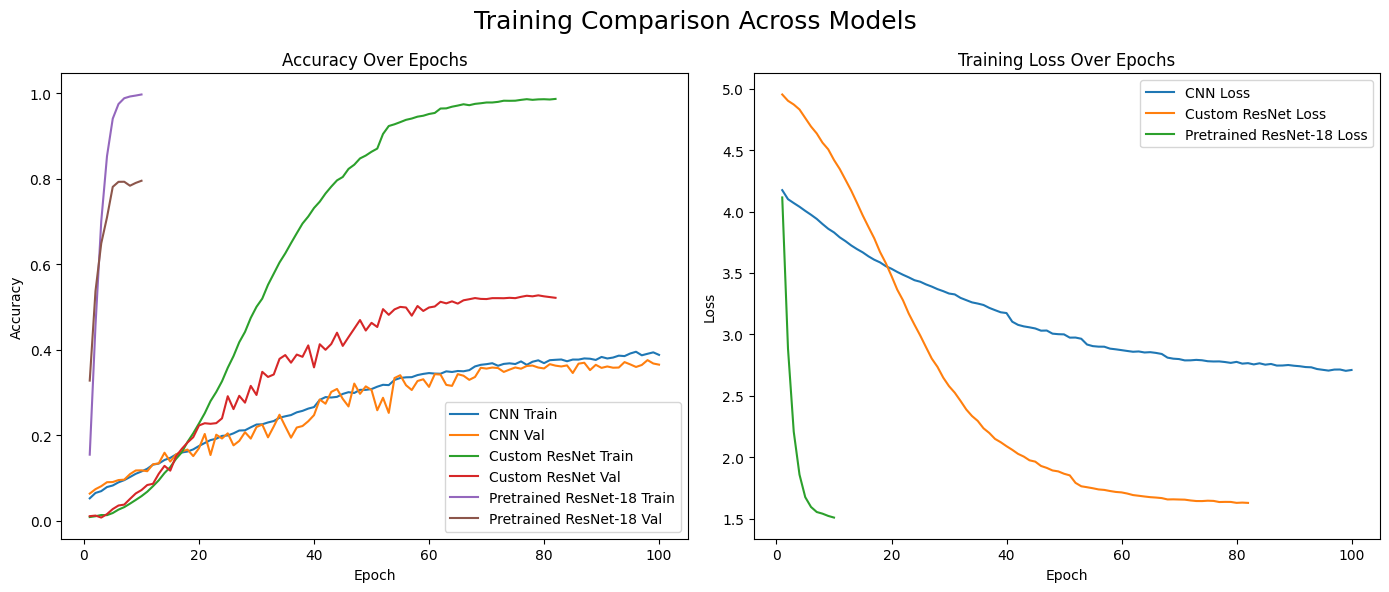

In [ ]:
# plotting the metrics fora ll models
results_dict = {
    "CNN": cnn_results,
    "Custom ResNet": resnet_results,
    "Pretrained ResNet-18": pretrained_results
}

plot_all_training_results(results_dict, title="Training Comparison Across Models", save_path="all_model_results.png")

## Model Evaluation

### Evaluation Functions

In [ ]:
# function to predict for all models
def predict(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    return preds, targets

In [ ]:
# function to get the log scale confusion matrix
def cm_heatmap_logscale(cm, labels, title, save_path=None):
    plt.figure(figsize=(18, 15))
    sns.heatmap(
        cm,
        annot=False,
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        norm=LogNorm(vmin=1, vmax=cm.max())  # Avoid log(0)
    )
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()

    # saving the confusion matrix to a file
    if save_path:
        plt.savefig(save_path)
        print(f"📊 Saved confusion matrix to {save_path}")
    plt.show()

In [ ]:
# function to get top-k accuracy for the models for top 1, 3, 5
def topk_accuracy_table(model, loader, class_labels, topk=(1, 3, 5)):
    model.eval()
    correct_topk = {k: 0 for k in topk}
    total = 0
    topk_classwise = {k: defaultdict(int) for k in topk}
    class_counts = defaultdict(int)

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, topk_preds = outputs.topk(max(topk), dim=1, largest=True, sorted=True)

            for i in range(labels.size(0)):
                true_label = labels[i].item()
                class_counts[true_label] += 1
                for k in topk:
                    if true_label in topk_preds[i][:k]:
                        correct_topk[k] += 1
                        topk_classwise[k][true_label] += 1

            total += labels.size(0)

    # Print overall Top-k accuracy
    for k in topk:
        acc = 100.0 * correct_topk[k] / total
        print(f"Top-{k} Accuracy: {acc:.2f}%")

    # Build results table
    results = []
    for idx, label in enumerate(class_labels):
        row = {"Class": label, "Samples": class_counts[idx]}
        for k in topk:
            correct = topk_classwise[k][idx]
            total_class = class_counts[idx]
            acc = 100.0 * correct / total_class if total_class > 0 else 0.0
            row[f"Top-{k}"] = round(acc, 2)
        results.append(row)

    df = pd.DataFrame(results)
    return df


In [ ]:
# function to get the distribution of top-k accuracies for the models
def model_hist(df_topk, title, save_path=None):
    plt.figure(figsize=(12, 6))
    for k in [1, 3, 5]:
        plt.hist(
            df_topk[f"Top-{k}"],
            alpha=0.7,
            label=f"{title} Top-{k}",
            bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        )
    plt.xlim(0, 100)
    plt.xlabel("Accuracy (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"{title} Top-k Accuracy Histogram")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"📊 Saved histogram to {save_path}")
    plt.show()

In [ ]:
# function to combine all the evaluation metrics for the models so that they can be run in one go
def evaluate_model(
    model,
    checkpoint_path,
    test_loader,
    label_names,
    topk_fn,
    heatmap_fn,
    hist_fn,
    model_name="Model",
    device=None,
    save_dir="results"
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📦 Evaluating: {model_name} | Device: {device}")

    # setup model directory for saving results
    model_dir = os.path.join(save_dir, model_name.replace(" ", "_"))
    os.makedirs(model_dir, exist_ok=True)

    # Load model
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()

    # Predict
    preds, targets = predict(model, test_loader)

    # Classification Report
    cr = classification_report(targets, preds, target_names=label_names)
    print(cr)

    # Save classification report as text
    with open(os.path.join(model_dir, "classification_report.txt"), "w") as f:
        f.write(cr)

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    heatmap_path = os.path.join(model_dir, "confusion_matrix_logscale.png")
    heatmap_fn(cm, label_names, f"{model_name} Confusion Matrix (Log Scale)", save_path=heatmap_path)

    # Top-k Accuracy Table + Histogram
    df_topk = topk_fn(model, test_loader, label_names)
    hist_path = os.path.join(model_dir, "topk_accuracy_histogram.png")
    hist_fn(df_topk, model_name, save_path=hist_path)

    # Save top-k accuracy table
    df_topk.to_csv(os.path.join(model_dir, "topk_accuracy_table.csv"), index=False)

    # Summary Dictionary for Metrics Table
    result = {
        "Model": model_name,
        "Top-1": round(np.average(df_topk['Top-1'], weights=df_topk['Samples']), 2),
        "Top-3": round(np.average(df_topk['Top-3'], weights=df_topk['Samples']), 2),
        "Top-5": round(np.average(df_topk['Top-5'], weights=df_topk['Samples']), 2),
        "Precision": round(precision_score(targets, preds, average='weighted'), 2),
        "recall": round(recall_score(targets, preds, average='weighted'), 2),
        "F1-Score": round(f1_score(targets, preds, average='weighted'), 2),
        "Macro F1-Score": round(f1_score(targets, preds, average='macro'), 2),
        "Support": round(np.sum(df_topk['Samples']), 2)
    }

    return result, df_topk, preds, targets

### Custom CNN

📦 Evaluating: Custom CNN | Device: cuda
              precision    recall  f1-score   support

         A10       0.32      0.27      0.29       106
       A400M       0.55      0.46      0.50        72
       AG600       0.77      0.42      0.55        40
        AH64       0.37      0.53      0.44        66
        AV8B       0.34      0.40      0.37        67
       An124       0.36      0.13      0.20        30
        An22       0.00      0.00      0.00        14
       An225       0.00      0.00      0.00        14
        An72       0.25      0.04      0.06        27
          B1       0.30      0.33      0.31        95
          B2       0.47      0.53      0.50        78
         B21       1.00      0.14      0.25         7
         B52       0.52      0.36      0.43        88
       Be200       0.56      0.33      0.42        45
        C130       0.49      0.58      0.53       217
         C17       0.49      0.46      0.48       104
          C2       0.47      0.66      0.

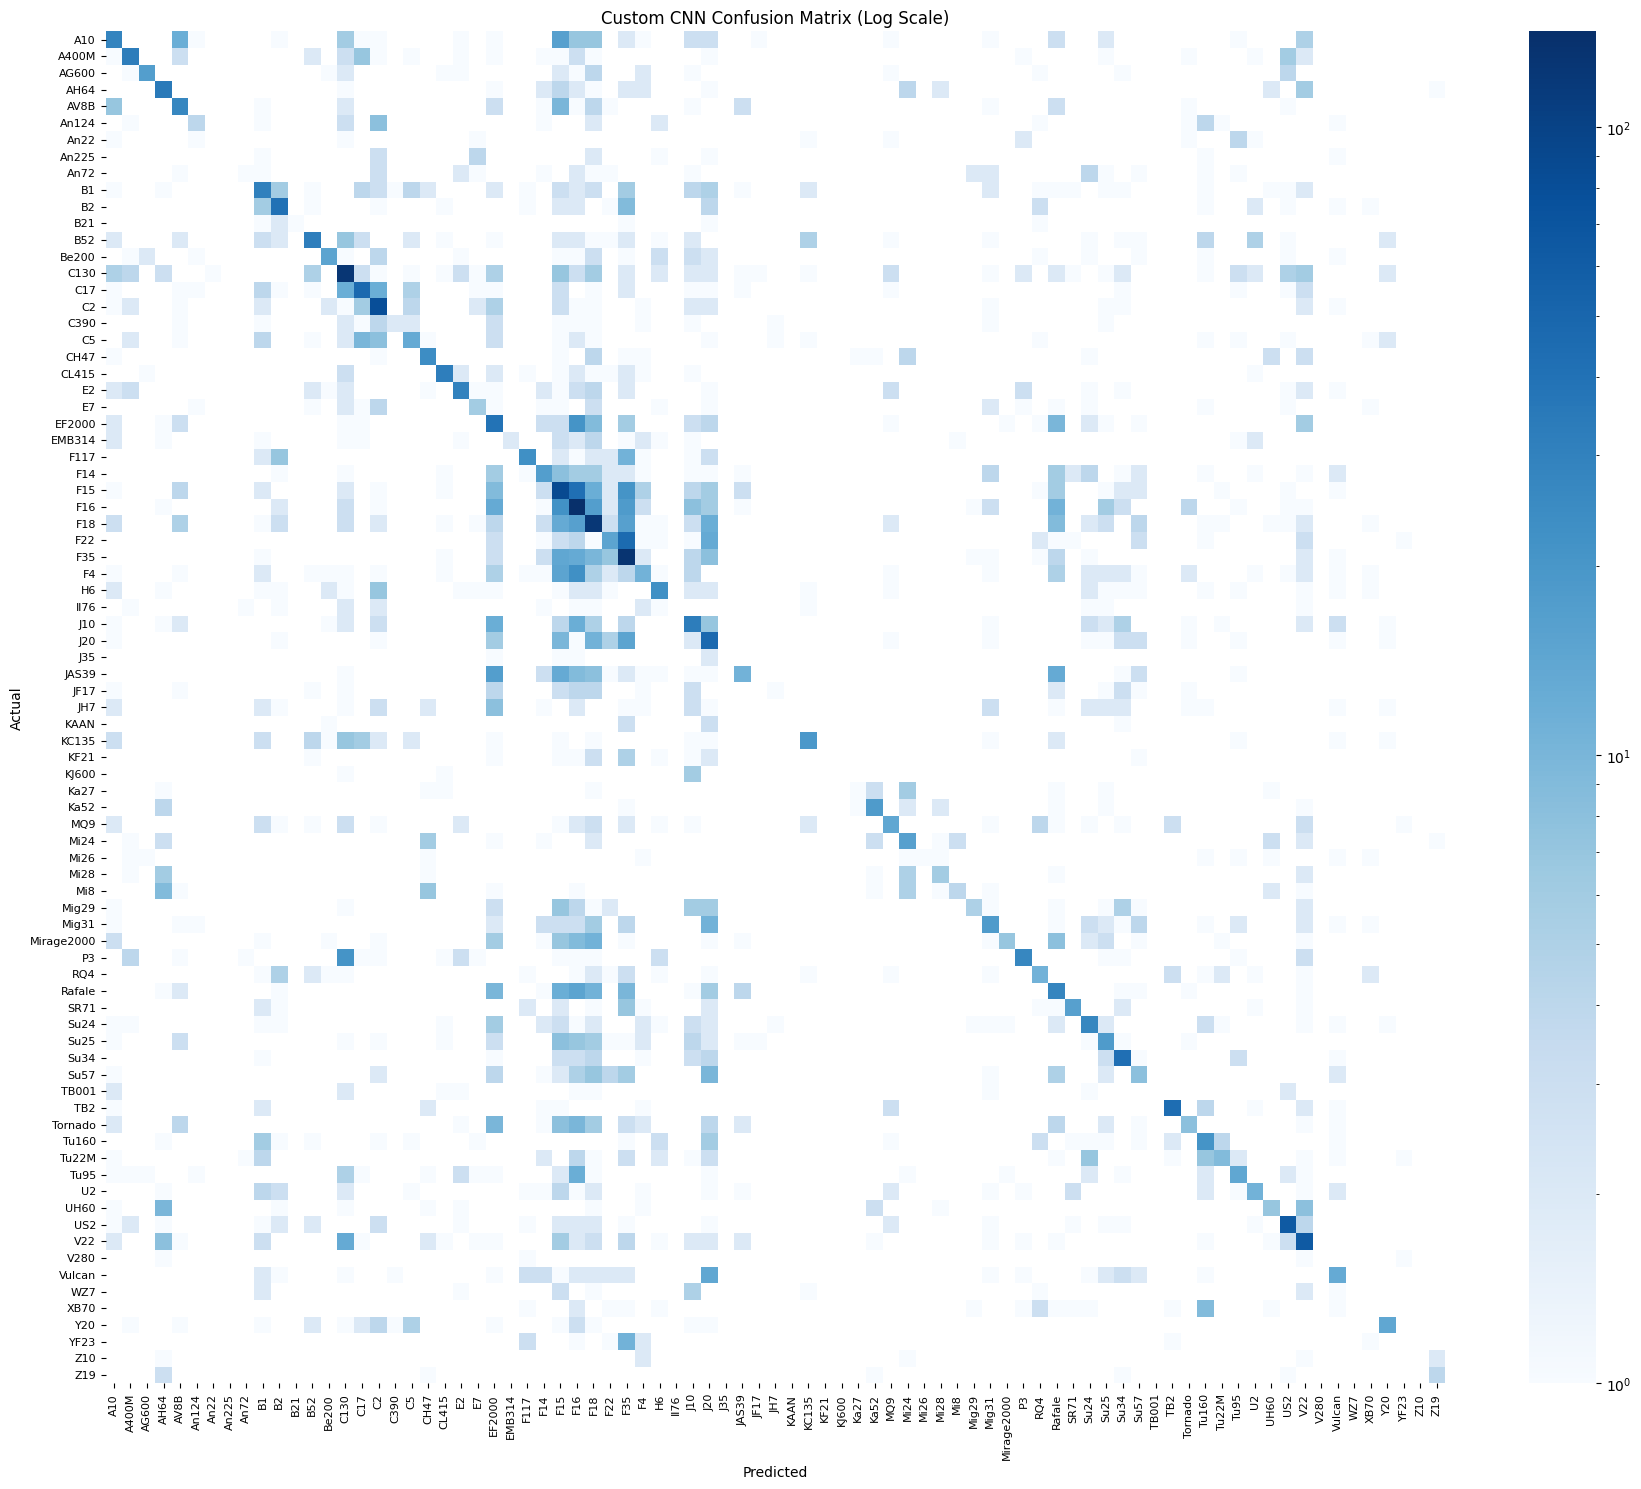

Top-1 Accuracy: 36.46%
Top-3 Accuracy: 56.99%
Top-5 Accuracy: 66.96%
📊 Saved histogram to results\Custom_CNN\topk_accuracy_histogram.png


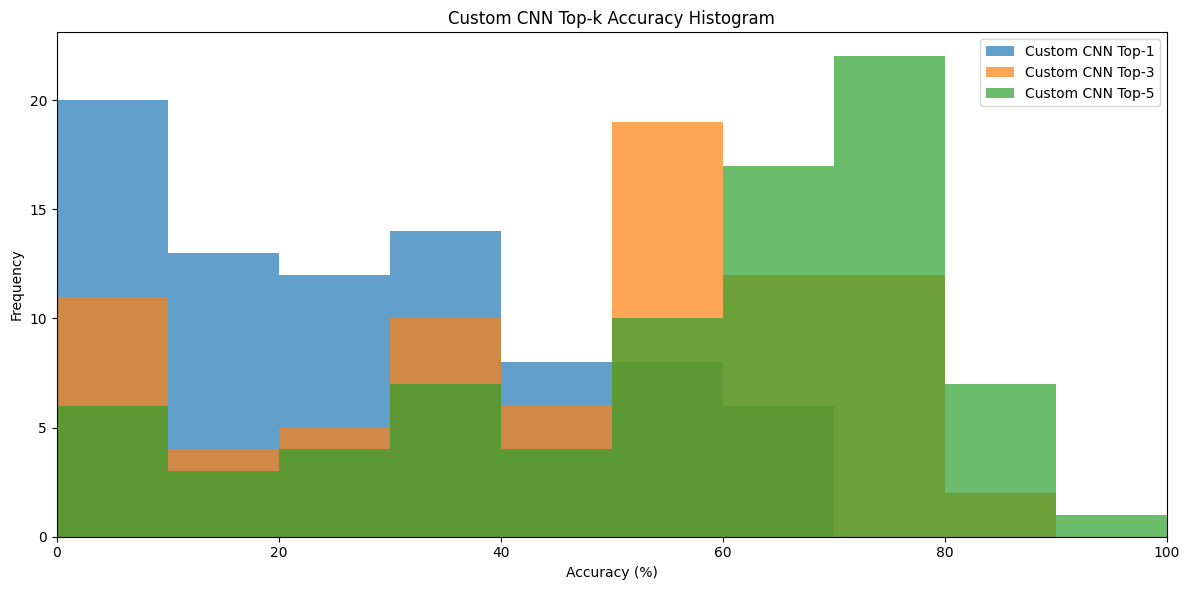

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

cnn_results, df_topk_cnn, cnn_preds, cnn_targets = evaluate_model(
    model=AircraftCNN(),
    checkpoint_path="best_aircraft_cnn.pth",
    test_loader=test_loader,
    label_names=unique_labels,
    topk_fn=topk_accuracy_table,
    heatmap_fn=cm_heatmap_logscale,
    hist_fn=model_hist,
    model_name="Custom CNN"
)

### Custom ResNet Like

📦 Evaluating: Custom ResNet Like | Device: cuda
              precision    recall  f1-score   support

         A10       0.57      0.49      0.53       106
       A400M       0.57      0.58      0.58        72
       AG600       0.69      0.45      0.55        40
        AH64       0.64      0.67      0.65        66
        AV8B       0.67      0.57      0.61        67
       An124       0.47      0.60      0.53        30
        An22       0.57      0.29      0.38        14
       An225       0.75      0.21      0.33        14
        An72       0.25      0.15      0.19        27
          B1       0.38      0.55      0.45        95
          B2       0.72      0.71      0.71        78
         B21       0.40      0.57      0.47         7
         B52       0.57      0.53      0.55        88
       Be200       0.59      0.53      0.56        45
        C130       0.70      0.69      0.69       217
         C17       0.45      0.56      0.50       104
          C2       0.68      0.58

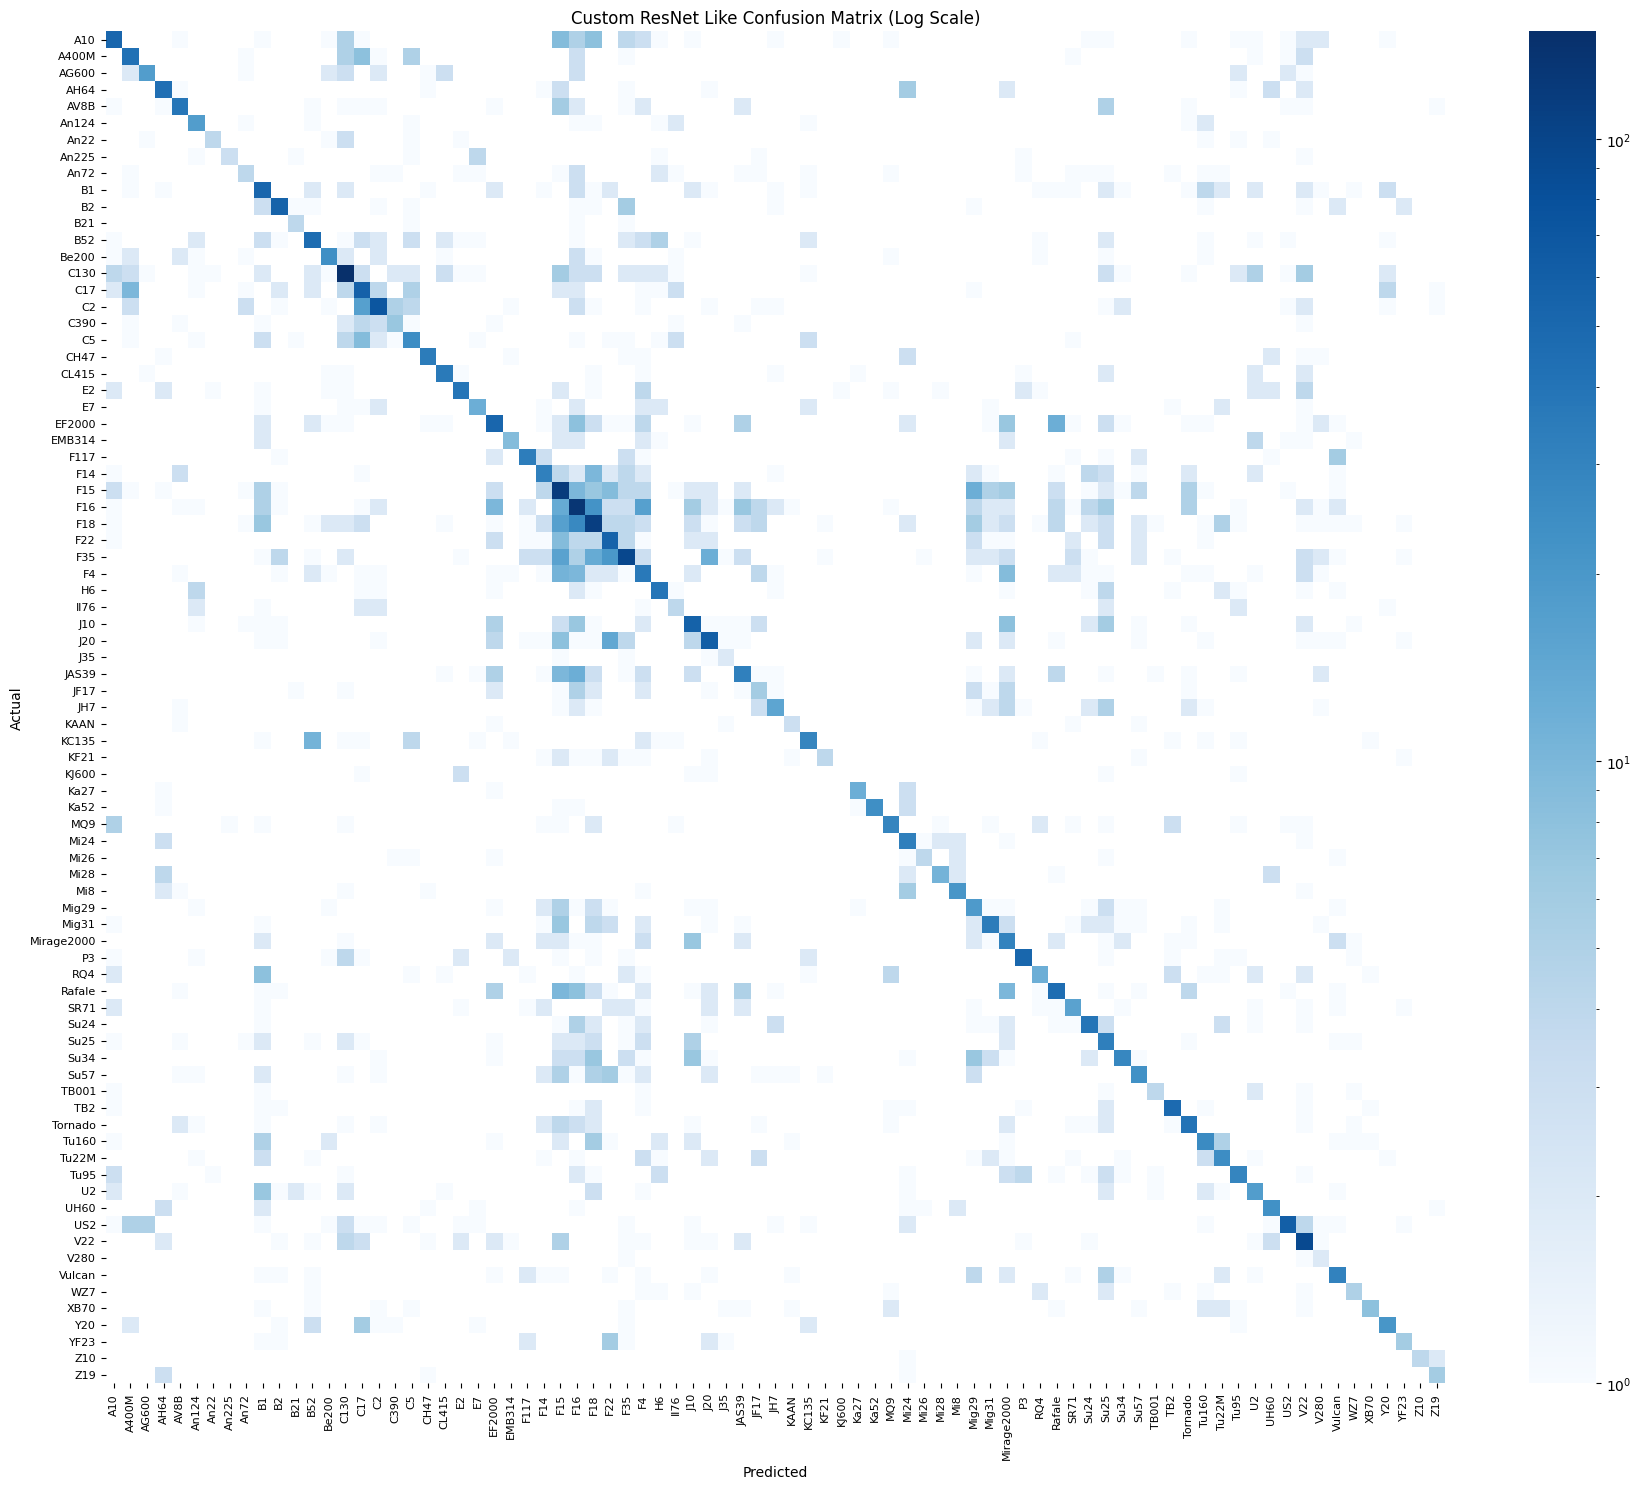

Top-1 Accuracy: 51.80%
Top-3 Accuracy: 64.83%
Top-5 Accuracy: 68.39%
📊 Saved histogram to results\Custom_ResNet_Like\topk_accuracy_histogram.png


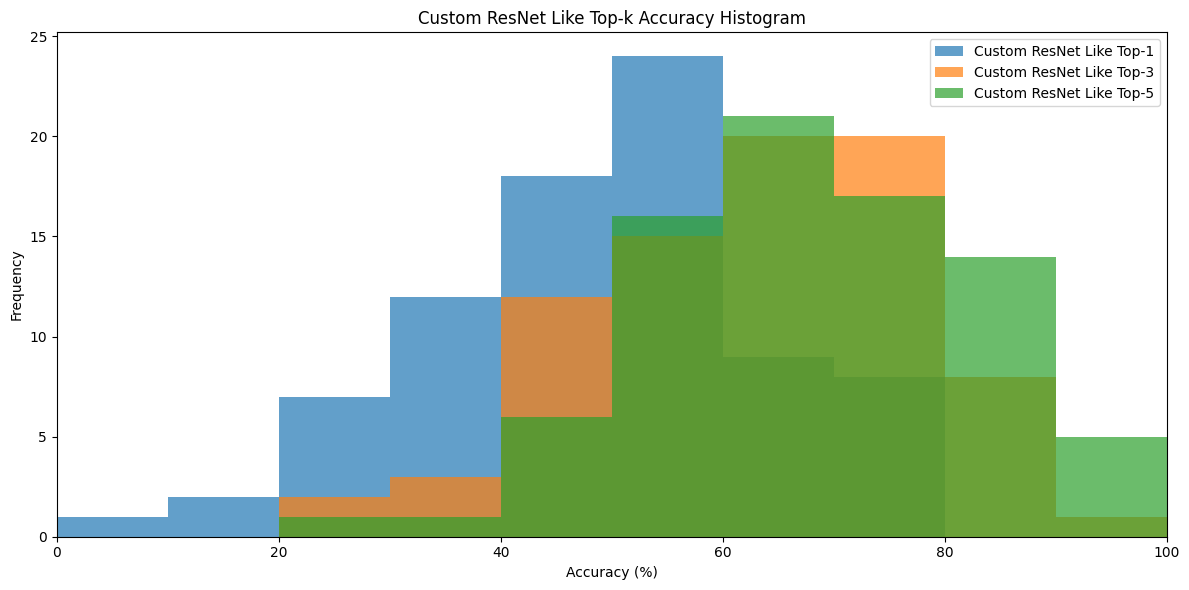

In [15]:
res_results, df_topk_res, res_preds, res_targets = evaluate_model(
    model=custom_resnet18(num_classes=81),
    checkpoint_path="best_aircraft_res.pth",
    test_loader=test_loader,
    label_names=unique_labels,
    topk_fn=topk_accuracy_table,
    heatmap_fn=cm_heatmap_logscale,
    hist_fn=model_hist,
    model_name="Custom ResNet Like"
)

### Pre-Trained ResNet-18

📦 Evaluating: Pre-Trained ResNet-18 | Device: cuda
              precision    recall  f1-score   support

         A10       0.74      0.85      0.79       106
       A400M       0.89      0.79      0.84        72
       AG600       0.86      0.80      0.83        40
        AH64       0.98      0.79      0.87        66
        AV8B       0.77      0.82      0.80        67
       An124       0.73      0.80      0.76        30
        An22       0.67      0.71      0.69        14
       An225       0.75      0.64      0.69        14
        An72       0.63      0.89      0.74        27
          B1       0.70      0.89      0.79        95
          B2       0.91      0.86      0.88        78
         B21       0.22      0.86      0.35         7
         B52       0.90      0.83      0.86        88
       Be200       0.95      0.78      0.85        45
        C130       0.93      0.80      0.86       217
         C17       0.81      0.85      0.83       104
          C2       0.90      0

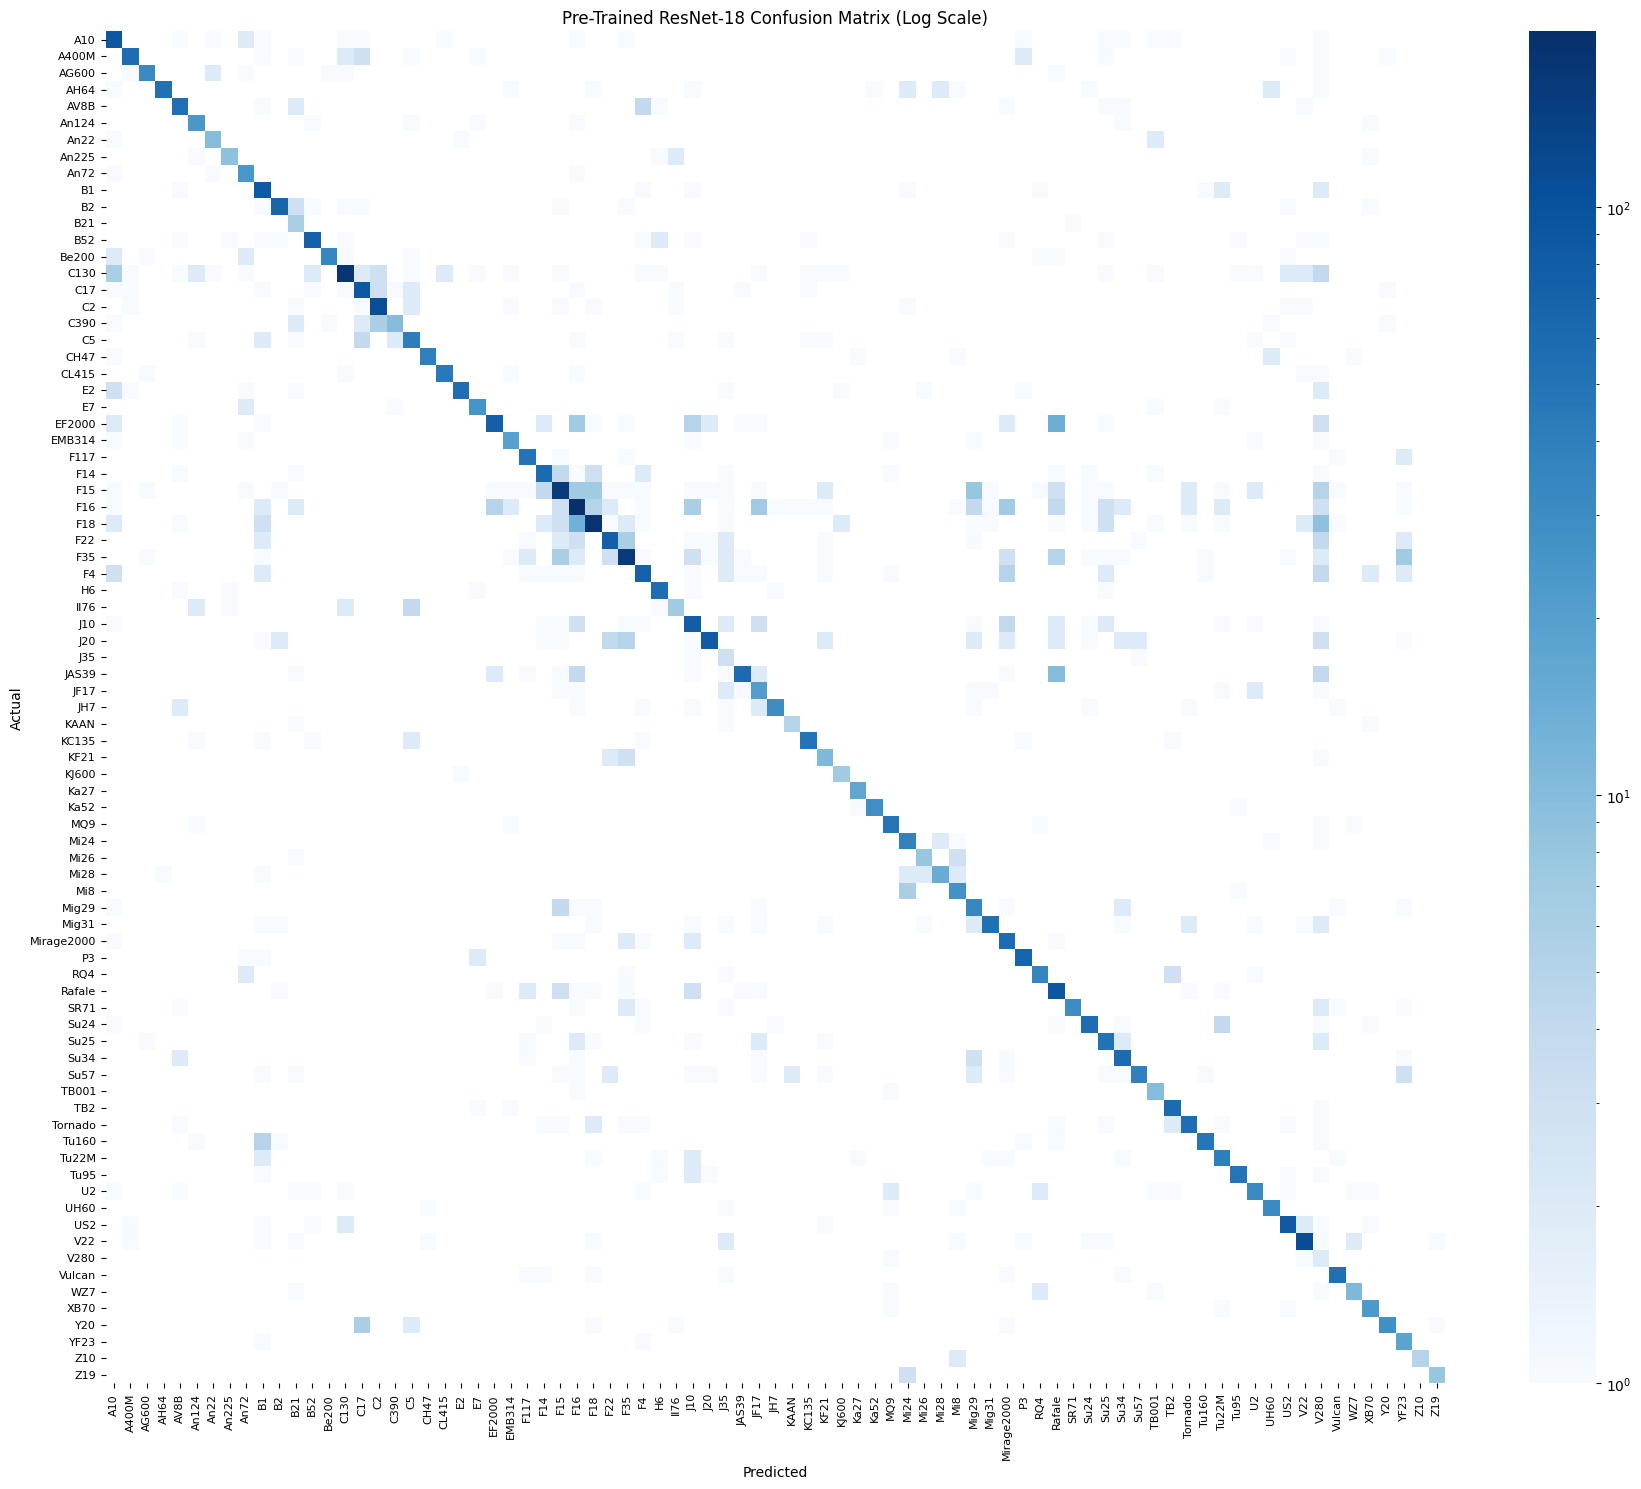

Top-1 Accuracy: 79.41%
Top-3 Accuracy: 86.69%
Top-5 Accuracy: 88.59%
📊 Saved histogram to results\Pre-Trained_ResNet-18\topk_accuracy_histogram.png


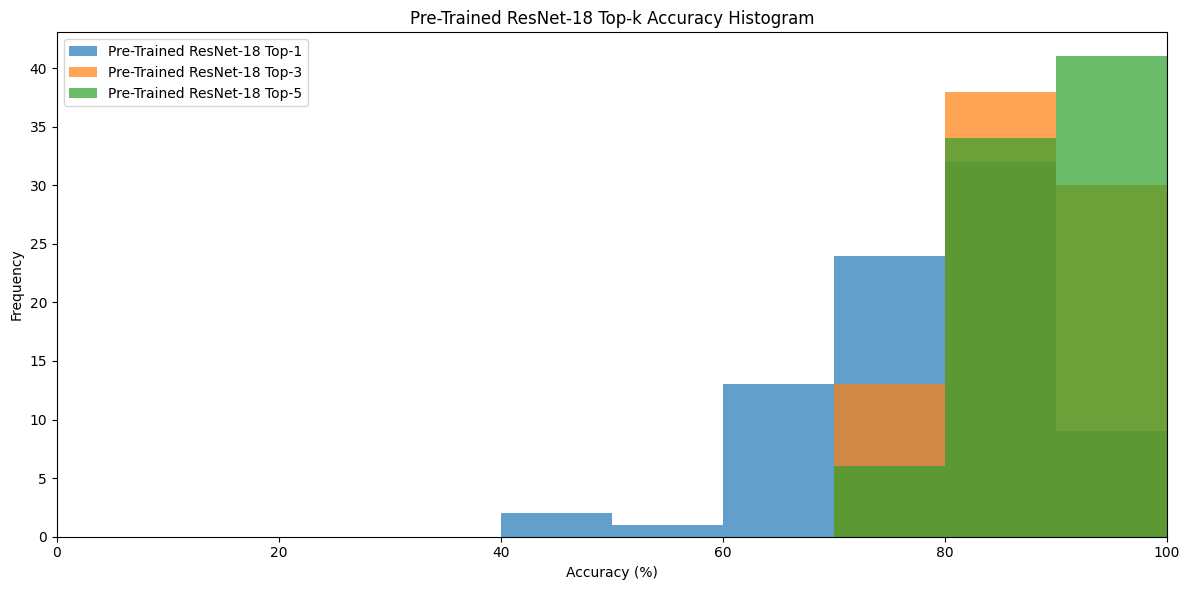

In [16]:
pt_res_results, df_topk_pt_res, pt_res_preds, pt_res_targets = evaluate_model(
    model=AircraftResNet(n_classes=81),
    checkpoint_path="best_resnet18_aircraft.pth",
    test_loader=test_loader,
    label_names=unique_labels,
    topk_fn=topk_accuracy_table,
    heatmap_fn=cm_heatmap_logscale,
    hist_fn=model_hist,
    model_name="Pre-Trained ResNet-18"
)

## Ensemble CNN Resnet Like

In [ ]:
# getting the softmax outputs for the custom cnn and resnet models 
def get_model_outputs(model, dataloader, device):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            assert images.dim() == 4, f"Expected 4D image tensor, got shape {images.shape}"
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_targets.extend(labels.numpy())

    return np.concatenate(all_probs), np.array(all_targets)


In [ ]:
# combining the softmax outputs of the models into a single 162 dimensional vector and transforming into tensor
class MetaDataset(Dataset):
    def __init__(self, probs1, probs2, labels):
        self.inputs = torch.tensor(np.hstack((probs1, probs2)), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [ ]:
# simlple MLP model to weigh the outputs of the two models and combine them into a single output
class EnsembleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(EnsembleMLP, self).__init__()
        # two fully connected layers with dropout
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [ ]:
# training loop for the meta model, similar to the previous train loop but with some differences for
def train_meta_model(model, train_loader, val_loader, device, num_epochs=1000, lr=0.001):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=4, factor=0.5)

    best_val_acc = 0
    best_model_state = None
    n_lr_reductions = 0
    patience_counter = 0
    prev_lr = lr
    
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0

        # training the model
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # getting validation metrics
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        
        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        scheduler.step(val_acc)
        
        # Check for learning rate reduction
        current_lr = optimizer.param_groups[0]["lr"]
        if current_lr != prev_lr:
            print(f"🔁 LR reduced to {current_lr}")
            patience_counter = 0
            n_lr_reductions += 1
        prev_lr = current_lr

        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"⚠️ No improvement for {patience_counter} epoch(s)")

        if optimizer.param_groups[0]['lr'] < 1e-6:
            n_lr_reductions += 1
        if n_lr_reductions >= 5:
            print("⛔ Early stopping triggered.")
            torch.save(best_model_state, "best_meta_model.pth")
            break
        
        if epoch == num_epochs - 1:
            print("🔁 Reached maximum epochs.")
            torch.save(best_model_state, "best_meta_model.pth")

    # Save the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

In [22]:
# Keep these for CNN/ResNet inference
image_val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
image_test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Loading the custom CNN and ResNet models
cnn_model = AircraftCNN().to(device)
res_model = custom_resnet18(num_classes=81).to(device)
cnn_model.load_state_dict(torch.load("best_aircraft_cnn.pth"))
res_model.load_state_dict(torch.load("best_aircraft_res.pth"))
cnn_model.eval()
res_model.eval()

# Get base model outputs on val & test (image-based loaders)
cnn_val_probs, val_targets = get_model_outputs(cnn_model, image_val_loader, device)
res_val_probs, _ = get_model_outputs(res_model, image_val_loader, device)

cnn_test_probs, test_targets = get_model_outputs(cnn_model, image_test_loader, device)
res_test_probs, _ = get_model_outputs(res_model, image_test_loader, device)

# Create meta-datasets using the softmax probabilities
meta_train_dataset = MetaDataset(cnn_val_probs, res_val_probs, val_targets)
meta_test_dataset = MetaDataset(cnn_test_probs, res_test_probs, test_targets)

# Use different names to avoid confusion with image-based loaders
meta_train_loader = DataLoader(meta_train_dataset, batch_size=64, shuffle=True)
meta_test_loader = DataLoader(meta_test_dataset, batch_size=64, shuffle=False)

# Define and train the meta-model
input_dim = cnn_val_probs.shape[1] * 2
num_classes = cnn_val_probs.shape[1]

print(input_dim)

meta_model = EnsembleMLP(input_dim=input_dim, hidden_dim=128, num_classes=num_classes).to(device)

meta_model = train_meta_model(
    model=meta_model,
    train_loader=meta_train_loader,
    val_loader=meta_test_loader,
    device=device,
    num_epochs=1000,
    lr=1e-3
)


Device: cuda
162
Epoch 1 | Train Acc: 0.0856 | Val Acc: 0.0960 | LR: 0.001000
Epoch 2 | Train Acc: 0.1375 | Val Acc: 0.1866 | LR: 0.001000
Epoch 3 | Train Acc: 0.2588 | Val Acc: 0.3370 | LR: 0.001000
Epoch 4 | Train Acc: 0.3604 | Val Acc: 0.4224 | LR: 0.001000
Epoch 5 | Train Acc: 0.4327 | Val Acc: 0.4656 | LR: 0.001000
Epoch 6 | Train Acc: 0.4626 | Val Acc: 0.4925 | LR: 0.001000
Epoch 7 | Train Acc: 0.4908 | Val Acc: 0.5131 | LR: 0.001000
Epoch 8 | Train Acc: 0.5159 | Val Acc: 0.5251 | LR: 0.001000
Epoch 9 | Train Acc: 0.5210 | Val Acc: 0.5319 | LR: 0.001000
Epoch 10 | Train Acc: 0.5366 | Val Acc: 0.5367 | LR: 0.001000
Epoch 11 | Train Acc: 0.5383 | Val Acc: 0.5421 | LR: 0.001000
Epoch 12 | Train Acc: 0.5385 | Val Acc: 0.5404 | LR: 0.001000
⚠️ No improvement for 1 epoch(s)
Epoch 13 | Train Acc: 0.5519 | Val Acc: 0.5442 | LR: 0.001000
Epoch 14 | Train Acc: 0.5468 | Val Acc: 0.5467 | LR: 0.001000
Epoch 15 | Train Acc: 0.5559 | Val Acc: 0.5465 | LR: 0.001000
⚠️ No improvement for 1 epoch

In [ ]:
# function to predict using the meta-model
def predict_meta_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return all_preds, all_labels

              precision    recall  f1-score   support

         A10       0.64      0.59      0.62       106
       A400M       0.61      0.60      0.61        72
       AG600       0.91      0.53      0.67        40
        AH64       0.60      0.76      0.67        66
        AV8B       0.78      0.60      0.68        67
       An124       0.41      0.53      0.46        30
        An22       0.67      0.29      0.40        14
       An225       1.00      0.07      0.13        14
        An72       0.39      0.26      0.31        27
          B1       0.42      0.62      0.50        95
          B2       0.72      0.67      0.69        78
         B21       0.00      0.00      0.00         7
         B52       0.66      0.57      0.61        88
       Be200       0.64      0.56      0.60        45
        C130       0.62      0.76      0.68       217
         C17       0.46      0.59      0.51       104
          C2       0.58      0.69      0.63       122
        C390       0.62    

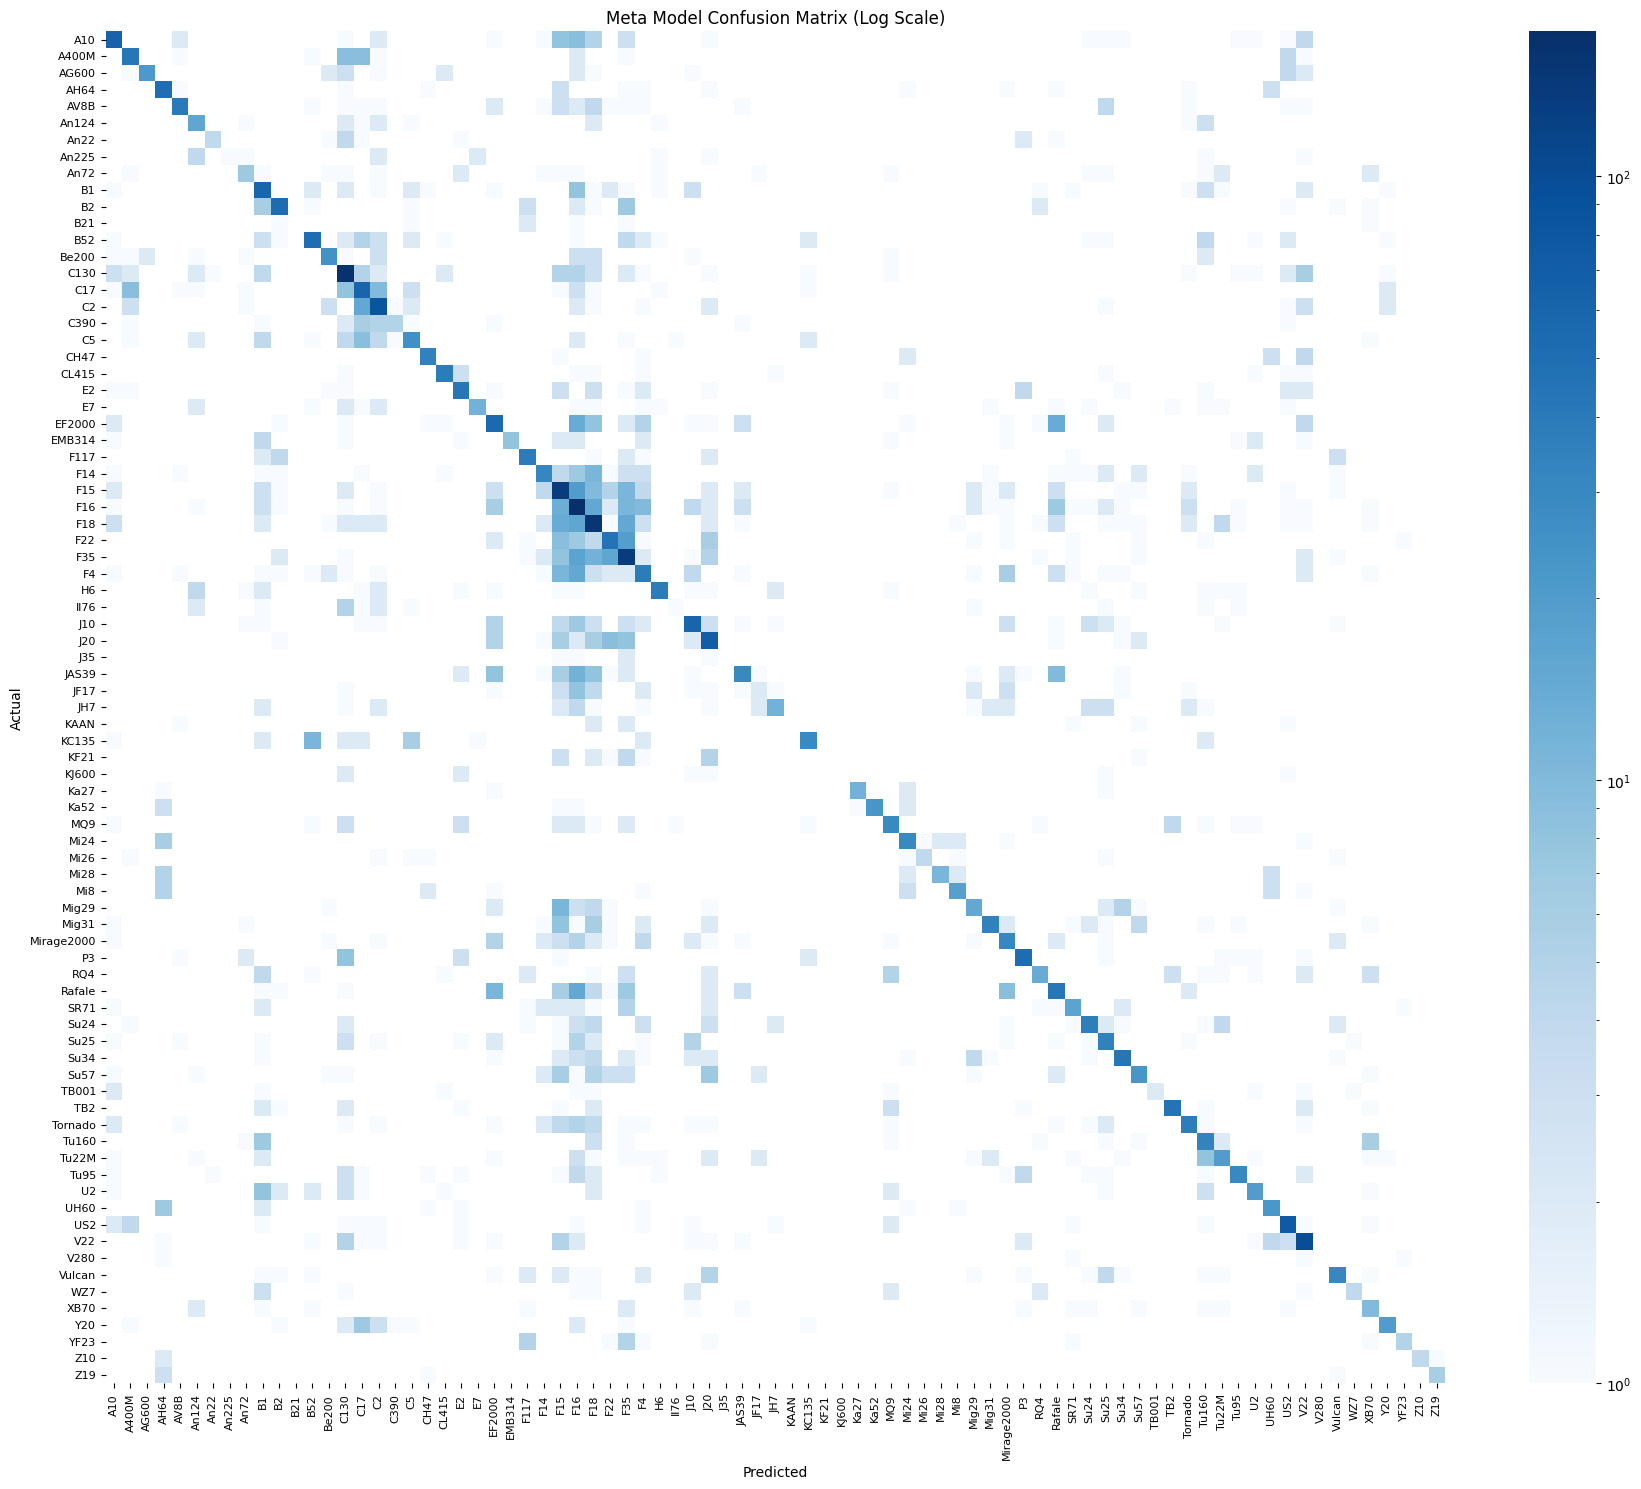

Top-1 Accuracy: 55.99%
Top-3 Accuracy: 70.76%
Top-5 Accuracy: 77.54%
📊 Saved histogram to results\meta_model\topk_accuracy_histogram.png


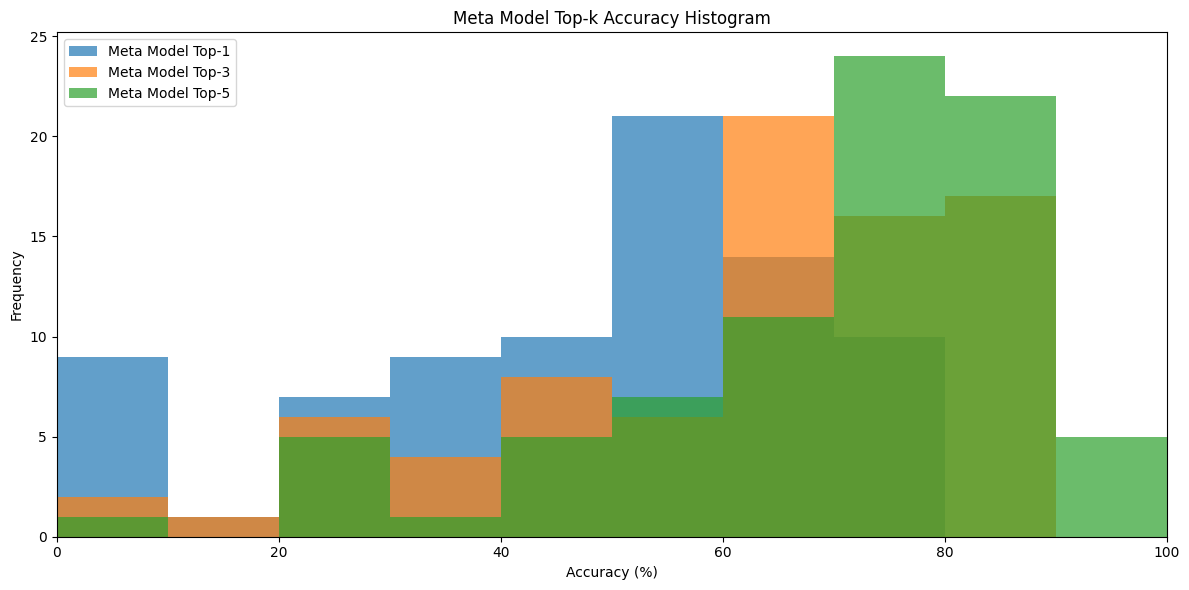

In [25]:
# save the meta model to results folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels = [label for label in unique_labels]  # same as before

model_dir = os.path.join("results", "meta_model")
os.makedirs(model_dir, exist_ok=True)

meta_model = EnsembleMLP(input_dim=162, hidden_dim=128, num_classes=81).to(device)

meta_model.load_state_dict(torch.load("best_meta_model.pth"))
meta_model.to(device)
meta_model.eval()

# Predict
meta_preds, meta_targets = predict_meta_model(meta_model, meta_test_loader, device)

# Classification report
meta_cr = classification_report(meta_targets, meta_preds, target_names=labels)
print(meta_cr)

with open(os.path.join(model_dir, "classification_report.txt"), "w") as f:
    f.write(meta_cr)
    
# Confusion Matrix
cm = confusion_matrix(meta_targets, meta_preds)
heatmap_path = os.path.join(model_dir, "confusion_matrix_logscale.png")
cm_heatmap_logscale(cm, labels, "Meta Model Confusion Matrix (Log Scale)", save_path=heatmap_path)

# Top-k Accuracy Table + Histogram
df_topk = topk_accuracy_table(meta_model, meta_test_loader, labels)
hist_path = os.path.join(model_dir, "topk_accuracy_histogram.png")
model_hist(df_topk, "Meta Model", save_path=hist_path)

# Save top-k accuracy table
df_topk.to_csv(os.path.join(model_dir, "topk_accuracy_table.csv"), index=False)

meta_results = {
        "Model": "Meta MLP Model",
        "Top-1": round(np.average(df_topk['Top-1'], weights=df_topk['Samples']), 2),
        "Top-3": round(np.average(df_topk['Top-3'], weights=df_topk['Samples']), 2),
        "Top-5": round(np.average(df_topk['Top-5'], weights=df_topk['Samples']), 2),
        "Precision": round(precision_score(meta_targets, meta_preds, average='weighted'), 2),
        "recall": round(recall_score(meta_targets, meta_preds, average='weighted'), 2),
        "F1-Score": round(f1_score(meta_targets, meta_preds, average='weighted'), 2),
        "Macro F1-Score": round(f1_score(meta_targets, meta_preds, average='macro'), 2),
        "Support": round(np.sum(df_topk['Samples']), 2)
}

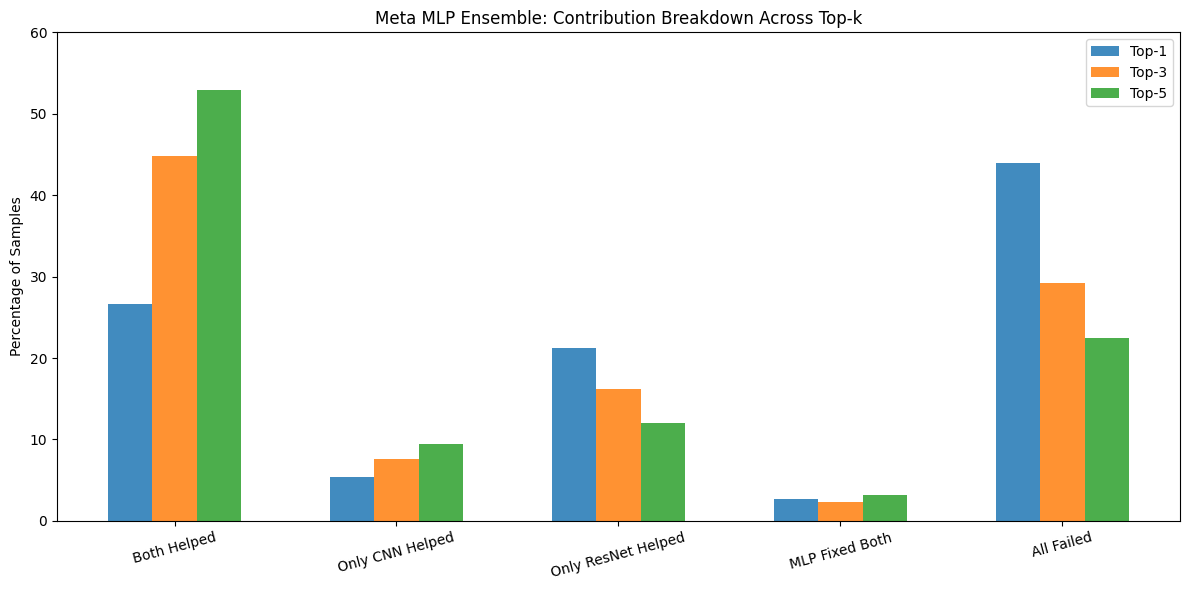

In [ ]:
# function to get top-k predictions for the models
def get_topk_predictions_generic(model, loader, device, k=3):
    model.eval()
    topk_preds = []
    targets = []

    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(device)
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)
            topk = torch.topk(probs, k=k, dim=1)
            topk_preds.extend(topk.indices.cpu().numpy())
            targets.extend(labels.numpy())

    return np.array(topk_preds), np.array(targets)

# function to analyze the contributions of the models to the top-k predictions
def analyze_topk_contributions(cnn_topk, res_topk, meta_topk, targets, k=3):
    contributions = defaultdict(int)

    for i in range(len(targets)):
        # Get the true label and check if it is in the top-k predictions of each model
        true_label = targets[i]
        cnn_hit = true_label in cnn_topk[i][:k]
        res_hit = true_label in res_topk[i][:k]
        meta_hit = true_label in meta_topk[i][:k]

        # Categorises a contribution based on if the model helped or not
        if meta_hit:
            if cnn_hit and res_hit:
                contributions["Both Helped"] += 1
            elif cnn_hit:
                contributions["Only CNN Helped"] += 1
            elif res_hit:
                contributions["Only ResNet Helped"] += 1
            else:
                contributions["MLP Fixed Both"] += 1
        else:
            contributions["All Failed"] += 1

    return contributions

# function to compute the contributions of the models to the top-k predictions for all k values
def compute_all_topk_contributions(topk_levels=[1, 3, 5]):
    results = {}
    for k in topk_levels:
        cnn_preds, targets = get_topk_predictions_generic(cnn_model, image_test_loader, device, k)
        res_preds, _ = get_topk_predictions_generic(res_model, image_test_loader, device, k)
        meta_preds, _ = get_topk_predictions_generic(meta_model, meta_test_loader, device, k)

        contrib = analyze_topk_contributions(cnn_preds, res_preds, meta_preds, targets, k)
        total = sum(contrib.values())
        results[k] = {key: (value / total) * 100 for key, value in contrib.items()}  # convert to percent
    return results

# plotting the results
def plot_grouped_topk_contributions(contribs_by_k):
    labels = ["Both Helped", "Only CNN Helped", "Only ResNet Helped", "MLP Fixed Both", "All Failed"]
    ks = sorted(contribs_by_k.keys())
    width = 0.2

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, k in enumerate(ks):
        values = [contribs_by_k[k].get(lbl, 0) for lbl in labels]
        ax.bar(x + (i - 1) * width, values, width=width, label=f"Top-{k}", alpha=0.85)

    ax.set_ylabel("Percentage of Samples")
    ax.set_title("Meta MLP Ensemble: Contribution Breakdown Across Top-k")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15)
    ax.set_ylim(0, 60)
    ax.legend()
    plt.tight_layout()
    plt.savefig("results/meta_model/topk_contributions.png")
    plt.show()

# Run the full analysis and plot
contribs_by_k = compute_all_topk_contributions(topk_levels=[1, 3, 5])
plot_grouped_topk_contributions(contribs_by_k)


## Overall Results

In [27]:
results = pd.DataFrame([cnn_results, res_results, pt_res_results, meta_results])

display(results)

results.to_csv("results/model_comparison_results.csv", index=False)

,Model,Top-1,Top-3,Top-5,Precision,recall,F1-Score,Macro F1-Score,Support
0,Custom CNN,36.46,56.99,66.96,0.37,0.36,0.35,0.28,5178
1,Custom ResNet Like,51.80,64.83,68.38,0.54,0.52,0.52,0.49,5178
2,Pre-Trained ResNet-18,79.41,86.69,88.59,0.82,0.79,0.80,0.76,5178
3,Meta MLP Model,55.99,70.76,77.54,0.58,0.56,0.55,0.50,5178
